# Results

In the below tables summarise the results for each dataset. 


The following represent the scenarios considered for the ML reconciliation approach:

```
CASE1 - When the validation loss considers only the bottom level time series

CASE2 - When the validation loss considers the entire hierarchy

```

For each CASE 1 and CASE 2 have different lambda configurations are carried out as below:

```
lambda_range = [0.01, 0.09]
lambda_range = [0.1, 0.9]
lambda_range = [1, 4]
lambda_range = 1
lambda_range = [0.01, 5]
```

Every data set has multiple samples

```
dataset_samples = {'prison': 3, 'tourism': 10, 'wikipedia': 10, 'labour': 5}
```

The results are also shown for full forecast horizon and half forecast horizon.
```
Prison : horizon = 8, half horizon = 4
Tourism: horizon = 12, half horizon = 6
Wikipedia: horizon = 7, half horizon = 3
Labour: horizon = 12, half horizon = 4
```

In [1]:
import pandas as pd

In [2]:
RESULTS_PATH = '../results/expanding_window_results/errors/'

In [3]:
def get_error_table(data_frame, LEVELS):
    errors = data_frame.groupby(by=['error_metric', 'level']).mean().reset_index().round(2)
    # level wise mean
    errors = pd.pivot(errors, values ='error', columns='error_metric', index='level')
    errors.index = LEVELS
    
    
    # overall is the mean across all time series 
    overall_error = data_frame.groupby(by='error_metric').mean()[['error']].transpose()
    overall_error.index = ['Overall']
    return errors.append(overall_error).round(2)

In [4]:
def get_percentage_improvement(base_df, approach_df):
    # shows the imporvement over base
    return ((base_df - approach_df)/base_df)*100

In [5]:
def get_results_per_sample(data, model, LEVELS, FC_TYPE, short_horizon = False, one_step = False):
    error_dic = {}
    error_tables = {}

    for fc_type in FC_TYPE:
        file_name = f'{data}_{model}'
        if short_horizon:
            if one_step:
                file_name = f'{file_name}_one_step_horizon'
            else:
                file_name = f'{file_name}_short_horizon'
        error_dic[fc_type] = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
        
    for fc_name, error_df in error_dic.items():
        error_tables[fc_name] = get_error_table(error_df, LEVELS)
        
    return error_tables

In [6]:
def get_results_across_samples(data, model, LEVELS, FC_TYPES, no_samples, short_horizon = False, one_step = False):
    fc_type_errors = {}
    error_percentages = {}
    final_percentage_tables = {}
    for fc_type in FC_TYPES:
        sample_results = []
        for sample in range(0, no_samples):
            file_name = f'{data}_{sample}_{model}'
            if short_horizon:
                if one_step:
                    file_name = f'{file_name}_one_step_horizon'
                else:
                    file_name = f'{file_name}_short_horizon'
            sample_error = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
            sample_results.append(get_error_table(sample_error, LEVELS))
        fc_type_all_samples = pd.concat(sample_results)
        mean_error = fc_type_all_samples.groupby(fc_type_all_samples.index).mean().reindex(sample_results[0].index.values)
        fc_type_errors[fc_type] = mean_error
        
    # get percentage improvement
    for fc_name, error_df in fc_type_errors.items():
        if fc_name == 'base':
            continue
        error_percentages[fc_name] = get_percentage_improvement(fc_type_errors['base'], error_df)
        
    # get a dataframe per error metric
    for error_metric in ['MSE', 'MAE', 'SMAPE']:
        dataframe_error = []
        for fc_name, error_df in error_percentages.items():
            error_metric_percentages = error_df[[error_metric]]
            error_metric_percentages.columns = [fc_name]  
            dataframe_error.append(error_metric_percentages)
        final_percentage_tables[error_metric] = pd.concat(dataframe_error, axis=1)[FC_TYPES[1:]] # excluding base reorder columns
    return final_percentage_tables, fc_type_errors['base'].round(3)

In [13]:
LEVELS_tourism = ['Australia', 'States', 'Regions']
LEVELS_prison = ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
LEVELS_labour = ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
LEVELS_wiki = ['Total', 'Access', 'Agent', 'Language', 'Purpose', 'Article']


FC_TYPE_toursim_labour = ['base', 'bottomup', 'ols', 'wls', 'mintsample', 'mintshrink', 'erm',
               'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']
#                'case1_lambda_1_no_skip',
#                'case1_lambda_[0.01, 0.09]_no_skip',
#                'case1_lambda_[0.1, 0.9]_no_skip',
#                'case1_lambda_[1, 4]_no_skip',
#                'case1_lambda_[0.01, 5]_no_skip',
#                'case2_lambda_1_no_skip',
#                'case2_lambda_[0.01, 0.09]_no_skip',
#                'case2_lambda_[0.1, 0.9]_no_skip',
#                'case2_lambda_[1, 4]_no_skip',
#                'case2_lambda_[0.01, 5]_no_skip']

FC_TYPE_prison_wiki = ['base', 'bottomup', 'ols', 'wls', 'mintshrink', 'erm',
               'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']
#                'case1_lambda_1_no_skip',
#                'case1_lambda_[0.01, 0.09]_no_skip',
#                'case1_lambda_[0.1, 0.9]_no_skip',
#                'case1_lambda_[1, 4]_no_skip',
#                'case1_lambda_[0.01, 5]_no_skip',
#                'case2_lambda_1_no_skip',
#                'case2_lambda_[0.01, 0.09]_no_skip',
#                'case2_lambda_[0.1, 0.9]_no_skip',
#                'case2_lambda_[1, 4]_no_skip',
#                'case2_lambda_[0.01, 5]_no_skip']

In [64]:
# write down all the results to summarise



data_mapping = {'prison': {'level': LEVELS_prison, 'fc_types': FC_TYPE_prison_wiki, 'num_samples': 3},
               'tourism': {'level': LEVELS_tourism, 'fc_types': FC_TYPE_toursim_labour, 'num_samples': 10},
               'labour': {'level': LEVELS_labour, 'fc_types': FC_TYPE_toursim_labour, 'num_samples': 5},
               'wikipedia': {'level': LEVELS_wiki, 'fc_types': FC_TYPE_prison_wiki, 'num_samples': 10}}

for data in ['prison', 'tourism', 'labour', 'wikipedia']:
    dataset_errors = []
    for model in ['arima', 'ets', 'deepAR', 'waveNet']:
        level = data_mapping[data]['level']
        fc_types = data_mapping[data]['fc_types']
        samples = data_mapping[data]['num_samples']
        full_h, _ = get_results_across_samples(data, model, level, fc_types, samples)
        short_h, _ = get_results_across_samples(data, model, level, fc_types, samples, True)
        one_step, _ = get_results_across_samples(data, model, level, fc_types, samples, True, True)
        
        full_h_dic = dict(full_h['MSE'].transpose()['Overall'])
        short_h_dic = dict(short_h['MSE'].transpose()['Overall'])
        one_step_dic = dict(one_step['MSE'].transpose()['Overall'])
        bestml_error_full = -10000000
        bestml_name_full = None
        bestml_error_short = -10000000
        bestml_name_short = None
        bestml_error_onestep = -10000000
        bestml_name_onestep = None
        
        for name_method, error in full_h_dic.items():
            if 'lambda' in name_method:
                if bestml_error_full < error:
                    bestml_error_full = error
                    bestml_name_full = name_method
            else:
                dataset_errors.append([model, 'full horizon', name_method, error])
        dataset_errors.append([model, 'full horizon', 'bestML', bestml_error_full])
            
        for name_method, error in short_h_dic.items():
            if 'lambda' in name_method:
                if bestml_error_short < error:
                    bestml_error_short = error
                    bestml_name_short = name_method
            else:
                dataset_errors.append([model, 'short horizon', name_method, error])
        dataset_errors.append([model, 'short horizon', 'bestML', bestml_error_short])
            
        for name_method, error in one_step_dic.items():
            if 'lambda' in name_method:
                if bestml_error_onestep < error:
                    bestml_error_onestep = error
                    bestml_name_onestep = name_method
            else:
                dataset_errors.append([model, 'one step horizon', name_method, error])
        dataset_errors.append([model, 'one step horizon', 'bestML', bestml_error_onestep])
            
    df_dataset = pd.DataFrame(dataset_errors, columns = ['base model', 'horizon', 'reconciliation method', 'overall improvement'])
    df_dataset.to_csv(f'{RESULTS_PATH}/summary/{data}.csv')

# ARIMA

#### Prison

In [16]:
prison_arima, prison_base_arima = get_results_across_samples('prison', 'arima', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintshrink,wls,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.1, 0.9]",case2_lambda_1,case1_lambda_1,"case2_lambda_[0.01, 5]","case2_lambda_[0.01, 0.09]",erm,...,bottomup,"case1_lambda_[0.1, 0.9]_no_skip","case1_lambda_[0.01, 5]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case2_lambda_[0.1, 0.9]_no_skip","case2_lambda_[1, 4]_no_skip","case1_lambda_[1, 4]_no_skip","case2_lambda_[0.01, 0.09]_no_skip",case2_lambda_1_no_skip,case1_lambda_1_no_skip
Australia,-0.376474,-21.595263,-29.368828,-52.004823,-53.924675,-52.541785,-57.842114,-48.896281,-59.010236,-64.698673,...,-85.184859,-83.951945,-110.253734,-154.910095,-135.092250,57.309808,-568.107466,-1582.976132,-10547.098712,-10769.696872
State,-2.337901,-0.212427,-3.360065,5.878883,6.681785,5.693136,4.940520,-1.846168,0.078387,-1.123124,...,-8.303258,5.722875,-7.336106,-5.320741,-11.066479,49.082272,-182.358675,-460.886050,-3805.973828,-3860.731121
Gender,10.991227,15.652498,13.588740,20.639751,21.551454,20.472650,19.830223,14.280150,15.284998,19.853292,...,8.362062,21.289852,6.872132,10.650369,6.814857,55.520815,-144.736674,-431.939971,-3521.912668,-3563.542957
Legal,9.713573,13.723333,9.745320,21.391108,21.917765,20.918963,20.606162,18.478700,18.472201,13.268597,...,13.435319,1.757473,-24.518989,2.075157,-2.613826,16.839767,-191.970117,-507.664467,-3086.770131,-3159.614745
Indigenous,-3.263004,2.580198,-3.573616,7.002702,7.501852,6.597164,6.331988,4.418524,5.152248,-10.352146,...,0.000000,-156.336099,-89.125386,-27.579700,-169.713934,-1888.863326,-2233.968276,-622.317357,-4896.361085,-4716.188401
Overall,2.846935,-1.585825,-6.436928,-7.670971,-7.814908,-8.033334,-10.151998,-10.326884,-12.973408,-16.378410,...,-26.116513,-35.787630,-48.394850,-52.253305,-61.190613,-125.093182,-486.795289,-847.081502,-5957.581876,-6046.891355


In [17]:
prison_base_arima

error_metric,MAE,MSE,SMAPE
Australia,938.950,2098750.937,2.893
State,242.370,174012.530,7.320
Gender,138.697,81449.447,10.423
Legal,85.540,31131.627,16.587
Indigenous,42.730,8877.097,20.433
Overall,87.350,52548.670,17.070


#### Tourism

In [18]:
tourism_arima, tourism_base_arima = get_results_across_samples('tourism', 'arima', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintsample,"case2_lambda_[0.01, 5]",mintshrink,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",case1_lambda_1,"case1_lambda_[1, 4]",wls,...,bottomup,"case1_lambda_[0.01, 5]_no_skip","case2_lambda_[0.01, 0.09]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case1_lambda_[1, 4]_no_skip","case1_lambda_[0.1, 0.9]_no_skip",case2_lambda_1_no_skip,case1_lambda_1_no_skip,"case2_lambda_[0.1, 0.9]_no_skip","case2_lambda_[1, 4]_no_skip"
Australia,-5.335586,-11.916774,-36.618612,-43.692080,-50.934428,-54.498068,-56.359613,-61.328221,-64.640817,-72.954812,...,-135.309664,-124.701720,-133.164363,-142.702642,-345.889410,-504.381866,-360.737497,-385.213742,-539.936983,-414.161719
States,13.906779,20.118828,7.630359,9.139755,3.098196,0.436654,0.707501,-1.265192,-2.154646,-1.321376,...,-26.339682,-37.305856,-44.042061,-38.357460,-128.353464,-190.416194,-125.716011,-144.567928,-208.562845,-182.166443
Regions,6.004762,10.321277,7.607808,9.217807,4.362166,5.923655,4.460760,3.910880,3.664044,6.973004,...,0.000000,-34.204099,-36.506544,-38.184873,-873.182657,-225.731704,-878.543475,-867.269329,-276.950167,-907.424053
Overall,2.599386,1.820034,-15.527345,-18.493340,-24.977373,-27.449104,-28.565793,-31.883171,-33.939870,-37.505089,...,-79.232358,-82.551387,-89.496110,-92.931141,-358.916607,-360.239905,-366.682345,-383.755811,-392.679058,-417.228376


In [19]:
tourism_base_arima

error_metric,MAE,MSE,SMAPE
Australia,1399.515,3138967.091,5.669
States,354.996,274232.848,14.386
Regions,66.241,12209.759,33.080
Overall,105.707,70573.514,31.217


#### Labour

In [20]:
labour_arima,labour_base_arima  = get_results_across_samples('labour', 'arima', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintshrink,wls,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case2_lambda_[1, 4]",case1_lambda_1,"case1_lambda_[1, 4]",...,"case2_lambda_[0.01, 5]_no_skip",erm,"case2_lambda_[0.01, 0.09]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case2_lambda_[1, 4]_no_skip","case1_lambda_[0.1, 0.9]_no_skip","case2_lambda_[0.1, 0.9]_no_skip","case1_lambda_[1, 4]_no_skip",case2_lambda_1_no_skip,case1_lambda_1_no_skip
Total Employees,-6.672240,-58.133884,-69.990394,-83.965672,-100.012921,-101.043306,-101.533024,-123.312249,-117.532903,-124.261654,...,-624.184138,-197.354060,-1089.483265,-1099.311533,-865.063014,-2204.544522,-2935.402797,-6462.671047,-8688.669160,-27327.314488
Main Occupation,11.624795,3.748077,2.810020,-4.368997,-8.044444,-8.522269,-8.449278,-10.519554,-14.127423,-11.467174,...,-182.302241,-393.005129,-217.915108,-237.054464,-547.345029,-374.444740,-512.917251,-1139.807643,-1639.725178,-3735.602582
Employment Status,9.122107,7.693827,7.665743,4.582503,2.966274,3.025529,1.533828,0.741453,-1.635671,0.019752,...,-60.205663,-281.967188,-72.983341,-100.192423,-283.291464,-149.754341,-220.250227,-612.281885,-773.920611,-2362.721973
Gender,5.801969,4.484556,4.939800,2.904778,1.824571,1.686800,1.100174,0.352215,-1.267895,-0.091049,...,-57.285306,-263.743386,-62.739053,-105.501667,-512.806741,-126.404169,-170.080067,-625.807959,-902.842481,-1893.262784
Overall,5.462109,-8.765127,-11.560076,-17.875625,-23.118853,-23.484033,-24.149930,-29.951077,-30.640843,-30.717159,...,-216.578903,-286.920425,-334.711729,-359.543631,-532.561081,-660.972038,-890.282872,-2057.738678,-2793.099417,-8188.577617


In [21]:
labour_base_arima

error_metric,MAE,MSE,SMAPE
Total Employees,101.116,15710.256,0.940
Main Occupation,35.882,2216.710,2.838
Employment Status,26.094,1296.104,4.528
Gender,15.136,500.830,5.874
Overall,22.634,1231.722,4.984


#### Wikipedia

In [22]:
wiki_arima, wiki_base_arima = get_results_across_samples('wikipedia', 'arima', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 5]","case1_lambda_[1, 4]","case1_lambda_[0.01, 5]",case1_lambda_1,mintshrink,bottomup,...,"case1_lambda_[0.01, 5]_no_skip","case2_lambda_[0.01, 5]_no_skip","case2_lambda_[0.01, 0.09]_no_skip","case1_lambda_[1, 4]_no_skip",case2_lambda_1_no_skip,"case2_lambda_[0.1, 0.9]_no_skip","case1_lambda_[0.1, 0.9]_no_skip","case2_lambda_[1, 4]_no_skip",case1_lambda_1_no_skip,"case1_lambda_[0.01, 0.09]_no_skip"
Total,24.445685,23.581556,21.672301,18.240414,22.351030,21.343346,28.101967,10.549538,9.169311,7.706422,...,-83.801020,-23.180525,-109.160761,-50.934264,-119.667117,-175.998857,-182.914924,-172.370486,-138.865115,-477.078170
Access,28.308490,26.883354,26.888924,23.922072,22.670549,20.133283,15.555193,19.772722,18.118666,17.194777,...,-73.971786,-82.959178,-100.643213,-43.202446,-124.951293,-117.640037,-124.819274,-117.915683,-173.411218,-495.324833
Agent,26.826098,23.655384,25.064284,22.108246,19.852424,17.397653,11.866217,17.457791,14.798932,14.745179,...,-83.089915,-106.258114,-100.237228,-48.990198,-118.190073,-114.991483,-124.090544,-134.357831,-175.707140,-976.517443
Language,21.310010,15.943330,16.091357,15.661455,9.843697,8.860220,1.220453,10.773867,5.339629,6.504378,...,-67.383331,-103.764523,-87.210353,-47.450234,-91.063472,-110.474793,-119.488215,-113.126356,-146.531508,-890.531808
Purpose,13.132319,11.791809,11.118746,9.259523,10.636721,11.239551,9.679013,7.148175,7.549667,6.431209,...,-314.736398,-321.158678,-315.410791,-222.614785,-295.608691,-277.425160,-288.973169,-303.287649,-315.424683,-1016.927415
Article,0.640863,0.584440,0.420419,0.314300,0.169259,0.330016,-0.004339,0.338767,-2.113828,0.000000,...,-2415.355152,-2684.107180,-2642.283553,-3322.974318,-3328.032362,-3238.261487,-3244.699501,-3323.318423,-3333.964397,-2320.993393
Overall,21.553351,19.450005,19.243517,16.972308,16.434842,15.130702,13.157822,12.496274,10.308578,10.027521,...,-334.307462,-360.027604,-373.990252,-387.658282,-449.779326,-451.819773,-460.073174,-466.871467,-487.071678,-889.956280


In [23]:
wiki_base_arima

error_metric,MAE,MSE,SMAPE
Total,6893.421,8.302591e+07,3.207
Access,3408.539,2.650665e+07,4.779
Agent,2142.522,1.543617e+07,7.120
Language,620.368,2.851467e+06,10.420
Purpose,106.495,3.075689e+05,38.791
Article,28.599,4.054379e+04,50.374
Overall,75.475,3.477905e+05,47.660


# ETS

#### Prison

In [24]:
prison_ets, prison_base_ets  = get_results_across_samples('prison', 'ets', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.1, 0.9]_no_skip","case2_lambda_[0.1, 0.9]_no_skip",case1_lambda_1,ols,mintshrink,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",case2_lambda_1,wls,...,"case2_lambda_[0.01, 5]_no_skip",erm,bottomup,"case2_lambda_[0.01, 0.09]_no_skip","case1_lambda_[0.01, 5]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case1_lambda_[1, 4]_no_skip",case1_lambda_1_no_skip,case2_lambda_1_no_skip,"case2_lambda_[1, 4]_no_skip"
Australia,55.746632,44.369264,-12.241386,3.350173,-7.769111,-15.939576,-24.977469,-25.304185,-25.197655,-16.780468,...,-54.608117,-47.001402,-80.458273,-74.144803,-225.992537,-353.853050,-92.728087,-135.901531,-135.901531,-15773.222919
State,32.176919,27.667956,12.858728,3.431335,6.488466,12.534829,15.349799,11.310384,8.364386,4.536444,...,14.489061,-21.616521,-4.131988,-0.422191,-24.565550,-67.126636,-5.133124,-112.646431,-112.646431,-5440.569611
Gender,31.859853,27.044701,16.113205,6.200481,9.954225,13.086547,19.475062,13.128125,12.363755,8.202444,...,12.411927,-17.067481,-0.156672,-4.018052,-14.956167,-66.364246,-5.583163,-167.395574,-167.395574,-5752.839079
Legal,-16.138640,-21.867434,10.478308,1.515096,3.963376,5.259786,11.208066,5.020996,8.060559,-1.598015,...,-28.896923,-3.359377,-1.525573,-57.215966,-68.386113,-44.185413,-6.802945,-221.665584,-221.665584,-4975.705420
Indigenous,-142.592525,-148.487758,9.171141,2.291990,4.899927,5.053128,9.954205,4.870138,7.324568,-2.455657,...,-68.166098,-9.257556,0.000000,-73.690444,-75.968478,-56.515415,-2426.483613,-2574.813761,-2574.813761,-5644.572823
Overall,17.422570,10.154066,4.007237,3.545823,1.645040,0.963415,0.927508,-2.639545,-2.774130,-3.744999,...,-23.798437,-25.956634,-29.354749,-41.614564,-104.148934,-163.137688,-260.470545,-374.366508,-374.366508,-9068.694437


In [25]:
prison_base_ets

error_metric,MAE,MSE,SMAPE
Australia,937.090,2101527.780,2.947
State,251.973,173626.090,7.577
Gender,128.400,69957.363,11.350
Legal,77.990,26214.187,16.350
Indigenous,41.917,8694.483,20.587
Overall,84.180,49629.380,17.240


#### Tourism

In [26]:
tourism_ets, tourism_base_ets = get_results_across_samples('tourism', 'ets', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,case2_lambda_1,mintsample,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.1, 0.9]","case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case1_lambda_[1, 4]",...,bottomup,"case1_lambda_[0.01, 5]_no_skip","case2_lambda_[0.01, 0.09]_no_skip",erm,"case2_lambda_[0.1, 0.9]_no_skip","case1_lambda_[0.1, 0.9]_no_skip","case1_lambda_[1, 4]_no_skip",case2_lambda_1_no_skip,case1_lambda_1_no_skip,"case2_lambda_[1, 4]_no_skip"
Australia,-2.344971,-3.489696,-6.193498,-13.590994,-19.938801,-23.636212,-24.155448,-23.258208,-25.517870,-27.511820,...,-73.461471,-69.427460,-96.546702,-201.751914,-395.167029,-481.708698,-566.062104,-583.831392,-732.328034,-747.836617
States,6.299921,2.631667,3.362105,-1.871790,-5.973677,-6.776672,-6.561433,-9.239514,-7.630561,-7.680785,...,-28.783638,-52.146649,-66.949454,-179.381350,-234.267652,-291.278128,-327.838619,-306.873248,-390.826081,-404.856332
Regions,4.908106,4.200455,4.965584,4.079795,3.131793,2.906860,3.072824,2.836947,2.711135,2.740101,...,0.000000,-64.900229,-60.507738,-188.407233,-301.938152,-295.233376,-1107.618543,-1083.267065,-1092.010151,-1105.016941
Overall,1.040280,-0.729556,-2.005030,-7.887722,-12.856356,-15.271942,-15.493763,-15.731261,-16.634062,-17.811132,...,-50.852333,-64.077817,-83.363777,-193.762840,-338.097197,-403.342393,-578.163525,-579.397002,-690.451516,-705.201893


In [27]:
tourism_base_ets

error_metric,MAE,MSE,SMAPE
Australia,1421.833,3275195.188,5.761
States,316.278,217616.857,12.721
Regions,61.531,10325.714,31.045
Overall,98.513,65806.981,29.241


#### Labour

In [28]:
labour_ets, labour_base_ets = get_results_across_samples('labour', 'ets', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 0.09]",case2_lambda_1,"case2_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]",bottomup,"case1_lambda_[1, 4]",...,"case1_lambda_[0.01, 5]_no_skip","case2_lambda_[1, 4]_no_skip","case2_lambda_[0.01, 0.09]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case1_lambda_[1, 4]_no_skip","case2_lambda_[0.1, 0.9]_no_skip","case2_lambda_[0.01, 5]_no_skip","case1_lambda_[0.1, 0.9]_no_skip",case1_lambda_1_no_skip,case2_lambda_1_no_skip
Total Employees,57.303180,57.877312,56.412764,54.111950,52.488516,52.352860,50.205386,49.831468,48.352039,44.109780,...,-193.452155,-171.137013,-234.424152,-300.722856,-217.310661,-388.051299,-480.241858,-556.876199,-1636.486444,-1838.345808
Main Occupation,9.863274,7.923089,8.162158,7.102765,10.114882,8.974562,4.706799,4.838047,2.147658,3.044950,...,-274.602212,-255.884818,-239.922983,-259.737800,-392.170790,-394.009424,-436.905174,-517.601163,-1297.894249,-1420.617404
Employment Status,9.815692,7.775857,9.110025,8.333375,10.324272,9.757568,6.155581,5.995407,4.641697,5.347530,...,-136.027225,-124.735563,-129.877156,-131.751138,-239.835317,-207.500438,-297.295586,-276.290116,-816.616477,-884.204768
Gender,3.765558,2.414945,3.285931,2.504145,4.330648,3.638529,1.152131,0.861646,0.000000,0.736953,...,-123.551664,-462.699358,-111.728663,-117.776999,-495.284530,-191.119206,-315.591360,-238.620432,-925.063398,-982.761004
Overall,37.865866,37.490741,36.925806,35.186832,35.128662,34.724668,32.019012,31.758931,30.184010,27.933605,...,-189.781209,-207.153482,-207.297569,-251.141755,-275.179157,-342.238236,-430.186085,-477.274067,-1393.678794,-1549.417303


In [29]:
labour_base_ets

error_metric,MAE,MSE,SMAPE
Total Employees,227.082,79633.560,2.134
Main Occupation,37.336,2424.408,2.908
Employment Status,25.358,1197.450,4.556
Gender,14.330,428.250,5.782
Overall,24.386,2313.894,4.970


#### Wikipedia

In [30]:
wiki_ets,wiki_base_ets  = get_results_across_samples('wikipedia', 'ets', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,wls,mintshrink,"case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]","case2_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]",ols,"case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",...,"case2_lambda_[0.01, 0.09]_no_skip","case2_lambda_[0.01, 5]_no_skip","case1_lambda_[0.01, 0.09]_no_skip","case1_lambda_[1, 4]_no_skip","case2_lambda_[1, 4]_no_skip",case2_lambda_1_no_skip,case1_lambda_1_no_skip,"case2_lambda_[0.1, 0.9]_no_skip","case1_lambda_[0.1, 0.9]_no_skip","case1_lambda_[0.01, 5]_no_skip"
Total,6.886495,5.058552,4.926538,9.560921,4.851799,5.420422,2.763498,0.821864,1.727492,-0.246187,...,-23.396650,-97.648737,-190.078692,-205.457464,-159.640002,-122.051329,-144.287012,-175.876240,-252.254803,-1128.158129
Access,3.415159,4.003577,3.946793,1.448715,1.492969,1.373072,0.507155,0.732885,-0.375257,-4.734692,...,-60.776637,-119.000989,-161.555627,-130.996154,-140.164496,-171.791764,-190.075079,-178.510750,-261.343603,-707.434480
Agent,3.165105,3.396779,3.252927,0.726491,1.055504,0.462921,0.011281,0.073095,-1.227151,-4.979850,...,-56.396039,-150.534148,-150.801612,-116.008799,-145.878902,-156.410984,-182.716064,-229.390984,-301.639758,-719.153537
Language,1.705704,1.740599,1.652369,-0.457095,-0.441959,-1.694663,-1.432547,0.062647,-4.090427,-6.108293,...,-49.855437,-118.686143,-113.520238,-97.422053,-104.091518,-126.738020,-140.571052,-183.762518,-234.072023,-543.394503
Purpose,-1.161008,-0.607535,-0.633640,-1.795119,-0.808200,-0.195079,-0.397281,-0.880863,-0.912196,-1.066410,...,-349.082489,-445.201695,-403.335403,-297.505443,-421.616801,-391.324276,-371.579112,-476.816355,-518.203655,-776.332582
Article,0.000000,0.393580,0.178841,-0.014429,-0.052131,-0.074579,-0.074748,0.010307,-0.168974,-0.139176,...,-2592.464479,-2675.752401,-2623.133233,-3516.142210,-3511.753568,-3520.553576,-3518.103451,-3413.704593,-3454.458560,-2734.145021
Overall,2.913736,2.792483,2.683243,2.210835,1.377824,1.233162,0.416339,0.240086,-0.720312,-3.070083,...,-368.010069,-445.845523,-462.482939,-537.614304,-550.849430,-551.830821,-564.934405,-586.640824,-651.094064,-1010.016066


In [31]:
wiki_base_ets

error_metric,MAE,MSE,SMAPE
Total,6331.976,6.813752e+07,2.977
Access,2909.886,2.027190e+07,4.230
Agent,1868.324,1.232725e+07,6.750
Language,581.665,2.501561e+06,10.084
Purpose,95.836,2.471231e+05,38.403
Article,27.646,3.840894e+04,50.299
Overall,69.351,2.862994e+05,47.533


# DeepAR

#### Prison

In [34]:
prison_deepar, prison_base_deepAR = get_results_across_samples('prison', 'deepAR', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,wls,mintshrink,ols,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case1_lambda_[1, 4]",erm,case1_lambda_1,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]"
Australia,60.607168,61.906973,66.553740,21.873006,19.547906,5.437759,-4.997006,-9.763718,-9.082369,49.722416,-14.442897,-5.284882,-26.376806,-25.934971,-120.652513
State,0.202785,-12.551283,-32.699464,-44.346639,-156.381889,-178.199099,-215.295141,-203.440492,-227.089867,-217.383874,-237.653921,-264.433633,-253.782014,-266.583913,-469.746106
Gender,8.770885,-3.701696,-16.459893,-22.080038,-116.570215,-139.661647,-168.685219,-159.938644,-175.257543,-232.115717,-184.026126,-212.830216,-190.436791,-202.320338,-387.482195
Legal,33.888474,20.335040,-12.632790,14.239954,-87.806607,-92.296957,-115.495433,-109.457468,-118.080786,-339.073075,-126.744007,-151.159517,-128.414501,-129.779744,-281.420467
Indigenous,0.000000,-20.424539,-73.117824,-22.067763,-137.196584,-165.508707,-168.970528,-160.805270,-170.674658,-627.424350,-180.087903,-238.544136,-225.481601,-183.713651,-402.544424
Overall,44.910144,41.310215,36.150748,8.723453,-26.673056,-42.086087,-57.780887,-58.136051,-62.635407,-65.552677,-69.293892,-73.006073,-81.555758,-82.076174,-206.160271


In [35]:
prison_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,2946.883,9949107.737,8.987
State,268.373,183786.977,8.243
Gender,129.793,85000.127,10.483
Legal,91.257,41601.657,15.827
Indigenous,39.907,9260.250,18.617
Overall,104.500,121514.997,16.037


#### Tourism

In [36]:
tourism_deepar, tourism_base_deepAR = get_results_across_samples('tourism', 'deepAR', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,mintshrink,wls,ols,"case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",mintsample,"case2_lambda_[0.01, 0.09]",case2_lambda_1,"case1_lambda_[1, 4]",case1_lambda_1,"case2_lambda_[0.01, 5]",bottomup,"case1_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",erm
Australia,10.670670,5.380768,4.052283,1.906765,1.635127,-0.111596,2.093888,-8.708260,-12.096676,-12.843470,-14.980779,-16.420205,-20.065363,-37.066355,-90.035106,-93.335044
States,4.867680,2.380355,-2.172799,-0.348809,-2.177847,-3.332330,-7.371086,-6.064631,-8.717820,-9.587850,-10.099937,-11.060914,-10.001498,-24.558000,-49.139215,-138.140773
Regions,3.835652,3.812352,0.228376,1.471196,1.643670,1.266351,-5.999434,0.747345,0.160895,-0.002037,-0.107750,-0.930820,0.000000,-3.689343,-7.040522,-146.148945
Overall,8.356440,4.429950,2.008331,1.284936,0.677064,-0.749479,-1.298806,-6.861121,-9.714288,-10.419088,-11.893585,-13.135606,-15.025262,-29.747121,-69.371910,-111.208512


In [37]:
tourism_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,1630.561,3996130.120,6.753
States,332.305,230337.429,13.450
Regions,61.806,10407.382,31.434
Overall,102.538,75410.124,29.660


#### Labour

In [38]:
labour_deepar, labour_base_deepAR = get_results_across_samples('labour', 'deepAR', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]",case1_lambda_1,mintshrink,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]",case2_lambda_1,wls,"case1_lambda_[1, 4]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]",mintsample,"case1_lambda_[0.1, 0.9]",ols,bottomup,erm
Total Employees,74.988034,75.425943,65.448446,48.432218,53.150288,63.475235,64.389540,37.097525,53.246194,46.873530,43.191050,49.428246,43.988003,3.878876,-13.490786,-297.165503
Main Occupation,42.575063,34.590257,31.624723,44.726172,36.078872,29.273326,21.020269,34.923923,19.737042,20.561622,10.859736,2.595865,0.185824,19.355107,8.134141,-958.962876
Employment Status,32.377933,26.762590,18.672851,37.541426,26.215327,11.817592,2.279563,37.782763,1.543881,5.940244,1.332210,-7.956019,-22.821017,31.630224,31.095345,-1167.026341
Gender,-2.773772,-9.520775,-8.826214,5.430169,-3.067023,-31.106938,-26.488331,5.726029,-28.237030,-22.789348,-46.868328,-66.366709,-60.027723,0.558555,0.000000,-2383.396492
Overall,52.957513,49.870263,42.649794,41.545785,39.241056,37.747463,35.147007,33.866829,28.872130,27.137561,20.173587,18.093384,12.511949,12.063456,0.777306,-793.573660


In [39]:
labour_base_deepAR

error_metric,MAE,MSE,SMAPE
Total Employees,255.162,94156.604,2.252
Main Occupation,49.214,4549.466,3.524
Employment Status,31.876,2244.992,4.860
Gender,15.828,536.742,6.062
Overall,29.218,3221.896,5.302


#### Wikipedia

In [40]:
wiki_deepar, wiki_base_deepAR = get_results_across_samples('wikipedia', 'deepAR', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,wls,ols,mintshrink,bottomup,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[1, 4]","case2_lambda_[0.01, 5]",case1_lambda_1,case2_lambda_1,"case2_lambda_[0.01, 0.09]",erm
Total,31.371093,14.870082,3.600639,-7.958939,-1.539730,-14.767232,-23.323188,-9.867369,-15.683069,-22.648639,-24.187960,-35.979988,-41.078947,-45.598907,-748.564171
Access,-5.819519,-5.730081,-23.931720,-48.345768,-59.622528,-74.762417,-89.488006,-104.379042,-98.796928,-95.815151,-105.860985,-112.377530,-107.411591,-116.681719,-909.126018
Agent,-2.092688,-4.133337,-18.616013,-41.350986,-58.325830,-75.443349,-87.262474,-95.376138,-93.176328,-94.205299,-102.774604,-107.349766,-106.460787,-111.440986,-846.734320
Language,36.561850,15.546458,23.336501,25.136964,2.171552,-8.076122,-15.257654,-16.580823,-16.017199,-20.797734,-21.428194,-19.965201,-20.365209,-29.955907,-471.808463
Purpose,8.651340,1.989381,0.460721,-6.396912,-10.562080,-21.792220,-23.288124,-24.389482,-24.108130,-36.401572,-18.353941,-25.464093,-24.247612,-35.761937,-685.176201
Article,-10.514328,-4.241574,-26.616657,0.000000,-3.554253,-3.446294,-4.753167,-4.398945,-3.712683,-6.574269,-3.873644,-3.922563,-4.228336,-5.737056,-680.928583
Overall,14.802043,5.466851,-3.333128,-12.482386,-20.741285,-33.007340,-41.375513,-41.805152,-41.930189,-46.200949,-47.364721,-52.949898,-53.354596,-60.333681,-721.892608


In [41]:
wiki_base_deepAR

error_metric,MAE,MSE,SMAPE
Total,9597.125,1.343287e+08,4.394
Access,3398.600,2.629070e+07,4.994
Agent,2266.738,1.632368e+07,7.255
Language,781.135,4.942228e+06,11.264
Purpose,116.586,3.911041e+05,39.847
Article,31.032,4.339818e+04,51.850
Overall,84.858,4.503426e+05,49.055


# WaveNet

#### Prison

In [42]:
prison_wavenet, prison_base_wavenet = get_results_across_samples('prison', 'waveNet', LEVELS_prison, FC_TYPE_prison_wiki, 3)
prison_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,"case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case1_lambda_1,"case1_lambda_[0.01, 5]",wls,ols,mintshrink,erm
Australia,99.966116,99.975723,99.969682,99.969900,99.933134,99.926342,99.936001,99.932731,99.904344,99.893528,99.871870,82.648706,34.339058,55.430338,-13.897567
State,78.487662,49.237120,36.969790,34.274558,10.743114,-9.324977,-4.195858,-10.980438,-11.582026,-30.562803,-54.601156,-14660.019599,-14036.377440,-29920.575266,-61486.439367
Gender,68.544288,23.689764,7.893505,2.675226,-29.338300,-55.528632,-58.505178,-71.423403,-68.161240,-87.416239,-122.650497,-23667.257807,-12270.065764,-45955.321314,-84976.053720
Legal,-38.710245,-317.642652,-401.196103,-416.139400,-556.297158,-666.979377,-763.786554,-865.455956,-790.881821,-835.523571,-976.582243,-106142.322795,-35407.428195,-166459.401551,-309713.564798
Indigenous,0.000000,-151.922717,-194.202359,-259.491767,-280.010816,-342.667135,-472.088867,-479.771689,-410.736454,-436.069085,-607.862911,-94077.830068,-19401.984242,-131326.820913,-238402.808312
Overall,99.929850,99.883312,99.857811,99.850408,99.780138,99.743244,99.742425,99.724614,99.704968,99.672797,99.608203,55.039256,18.984306,6.096855,-108.458034


In [43]:
prison_base_wavenet

error_metric,MAE,MSE,SMAPE
Australia,95594.753,2.219503e+10,76.157
State,595.613,1.614227e+06,14.307
Gender,241.290,4.618751e+05,18.070
Legal,90.490,4.027690e+04,14.843
Indigenous,53.520,1.835563e+04,20.850
Overall,913.563,1.836182e+08,18.917


#### Tourism

In [44]:
tourism_wavenet, tourism_base_wavenet = get_results_across_samples('tourism', 'waveNet', LEVELS_tourism, FC_TYPE_toursim_labour, 10)
tourism_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",case2_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]",case1_lambda_1,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",ols,wls,bottomup,mintshrink,mintsample,erm
Australia,50.695966,40.506145,39.764397,40.655187,39.548166,39.067629,38.772276,33.675258,28.521591,24.146054,15.002795,14.173741,8.292965,5.506702,-2.409644,-3.231635
States,17.589262,9.829972,10.853395,5.800487,6.057318,5.324789,6.341696,2.435383,-1.039034,-1.085953,-10.701036,-17.246993,-13.573072,-26.030867,-43.572515,-87.768410
Regions,6.952144,6.292494,6.323520,2.902579,2.590407,3.666567,2.894195,2.236288,2.966747,4.342771,-1.862939,-7.032882,0.000000,-6.889372,-14.746271,-110.113111
Overall,40.151274,31.326581,31.001188,30.330124,29.563294,29.179238,29.095060,24.645331,20.369333,17.375496,8.415015,6.065588,3.255077,-1.800173,-11.587178,-29.706611


In [45]:
tourism_base_wavenet

error_metric,MAE,MSE,SMAPE
Australia,2012.510,7091481.378,8.082
States,367.236,277527.034,15.394
Regions,64.674,12105.820,31.958
Overall,112.507,117250.810,30.315


#### Labour

In [46]:
labour_wavenet, labour_base_wavenet = get_results_across_samples('labour', 'waveNet', LEVELS_labour, FC_TYPE_toursim_labour, 5)
labour_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,mintshrink,wls,ols,"case2_lambda_[0.01, 0.09]",mintsample,"case2_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]",case1_lambda_1,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case1_lambda_[1, 4]",bottomup,erm
Total Employees,36.728159,14.059301,9.509493,46.395804,41.672247,29.248743,15.452227,7.697414,-2.796077,8.733537,24.344865,10.014070,19.801671,-19.727994,-268.221859,-75.074273
Main Occupation,3.453967,9.873968,6.652225,-43.834066,-56.219063,-44.363140,-40.409250,-47.598350,-37.553991,-44.584854,-56.787553,-51.569731,-61.337688,-66.282391,-95.319218,-2015.973716
Employment Status,-22.494422,-2.146457,-2.805930,-84.029053,-76.014020,-96.539347,-92.610129,-94.906674,-83.933687,-91.893647,-116.902268,-106.525763,-122.711901,-117.294293,-80.478664,-2251.085457
Gender,27.268288,40.087681,30.107160,4.123267,-9.400525,-3.248635,2.178124,-0.299001,3.386677,-10.093465,-14.041315,-4.539031,-14.000666,-11.421782,0.000000,-1413.401027
Overall,18.961016,16.197396,11.366832,-0.334817,-6.190323,-11.665869,-15.250879,-20.869651,-21.115225,-21.472405,-21.732437,-23.386865,-25.505710,-42.415594,-148.919827,-1067.651911


In [47]:
labour_base_wavenet

error_metric,MAE,MSE,SMAPE
Total Employees,185.882,48471.060,1.638
Main Occupation,38.126,2435.576,2.810
Employment Status,24.314,1136.664,4.058
Gender,17.106,733.108,6.216
Overall,25.040,1922.840,5.054


#### Wikipedia

In [48]:
wiki_wavenet, wiki_base_wavenet = get_results_across_samples('wikipedia', 'waveNet', LEVELS_wiki, FC_TYPE_prison_wiki, 10)
wiki_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[1, 4]",mintshrink,wls,ols,"case1_lambda_[0.1, 0.9]",bottomup,"case1_lambda_[1, 4]","case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]",case1_lambda_1,case2_lambda_1,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]",erm
Total,67.736485,50.049123,31.025088,20.774959,7.275891,6.222981,-14.485617,-6.148188,-55.384113,-49.272930,-99.105179,-245.533701,-256.005892,-493.300896,-5574.106281
Access,46.463546,49.858162,31.388279,25.686502,8.432302,6.240694,2.961813,-10.699799,-26.444579,-55.419154,-63.942911,-181.371347,-180.164014,-327.846471,-9788.063665
Agent,34.032834,40.273156,18.034211,13.024991,-9.927564,-11.470960,-10.427233,-27.372146,-46.238913,-81.136973,-90.999568,-212.536271,-207.646088,-378.178952,-11720.600328
Language,7.327764,9.586252,-19.535433,-12.383093,-50.319142,-60.101652,-43.870110,-70.841576,-99.228082,-149.629546,-151.243765,-302.147050,-277.176934,-480.654009,-13174.068936
Purpose,1.373139,14.476599,-14.955073,-2.152661,-29.574864,-46.549946,-34.933197,-32.022164,-36.882360,-83.433105,-107.548943,-136.949725,-149.410079,-283.190877,-13407.870280
Article,4.440947,28.805993,20.553198,4.452313,1.652819,0.000000,2.349771,1.470177,0.935749,-0.925750,-0.872118,-4.838575,-3.145494,-9.854862,-13100.847699
Overall,40.694484,39.980098,19.384671,14.382175,-4.536323,-8.136967,-12.788788,-18.923039,-45.281869,-65.697049,-87.947934,-203.432508,-204.262499,-379.728069,-9644.397040


In [49]:
wiki_base_wavenet

error_metric,MAE,MSE,SMAPE
Total,14999.774,3.147427e+08,6.813
Access,5586.828,7.723303e+07,7.406
Agent,3197.595,3.846198e+07,10.180
Language,776.617,4.384108e+06,12.454
Purpose,138.922,5.423167e+05,41.717
Article,38.395,7.185990e+04,54.689
Overall,109.214,8.904260e+05,51.729


# Short Horizon

# ARIMA

#### Prison

In [50]:
prison_arima, prison_base_arima = get_results_across_samples('prison', 'arima', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]",case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",ols,mintshrink,"case2_lambda_[1, 4]",wls,"case1_lambda_[0.01, 0.09]",bottomup,erm
Australia,-9.854020,-16.659761,-21.513500,-3.612473,-28.458823,-31.431944,-45.124092,-56.906080,0.344973,-23.011557,-58.089844,-26.388851,-56.335756,-68.497749,-84.971333
State,26.505127,23.671952,23.301517,14.184900,22.730223,13.516214,16.044322,16.167713,-0.847315,3.082141,11.158891,1.734511,3.827646,9.778114,4.128267
Gender,38.570602,35.945609,35.589027,28.775471,35.202158,27.784884,29.769429,31.147217,12.339005,17.570419,25.889264,16.809234,20.384290,24.015380,23.642371
Legal,26.205511,24.016024,24.504230,22.461428,23.758725,19.203721,21.527230,21.621400,6.704403,10.419498,18.303235,8.197154,17.132019,17.137894,10.430184
Indigenous,8.193787,6.139379,6.598330,4.792674,5.920250,1.804501,4.494234,3.934438,-9.281866,-5.030500,1.087449,-9.118833,2.163972,0.000000,-18.668569
Overall,19.551279,16.107174,15.014085,14.341722,13.064973,7.009533,5.880340,3.650136,3.049303,1.380133,-0.056177,-0.711669,-2.988671,-3.435935,-11.717106


In [51]:
prison_base_arima

error_metric,MAE,MSE,SMAPE
Australia,448.190,424954.230,1.450
State,143.170,63807.807,4.610
Gender,85.357,29077.033,7.157
Legal,51.143,11291.683,11.937
Indigenous,26.263,3173.177,16.180
Overall,51.873,16240.217,12.970


#### Tourism

In [52]:
tourism_arima, tourism_base_arima = get_results_across_samples('tourism', 'arima', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintsample,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]",mintshrink,"case2_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[1, 4]",wls,case2_lambda_1,erm,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",bottomup
Australia,-4.375702,-9.536273,-16.127576,-23.441320,-29.738952,-34.031863,-38.613678,-40.160405,-49.103110,-54.719870,-58.097942,-53.855336,-73.228566,-74.989913,-75.671605,-100.690111
States,13.663157,18.306512,15.509168,10.739723,9.378469,10.606140,6.976825,4.980608,3.555367,3.593696,2.289791,-19.279877,-4.353818,-3.404841,-4.123293,-15.201145
Regions,3.571507,7.620576,6.364655,3.703718,5.296254,6.744019,2.636957,2.787024,2.439614,4.789029,2.151947,-28.967532,0.977190,1.106171,2.591137,0.000000
Overall,2.726220,2.212140,-2.296106,-8.040015,-11.474811,-13.062054,-17.260000,-18.678892,-23.812081,-26.321752,-28.911016,-38.689797,-39.056822,-39.639109,-39.984139,-56.894485


In [53]:
tourism_base_arima

error_metric,MAE,MSE,SMAPE
Australia,1349.854,2953708.564,5.514
States,347.474,263839.026,14.397
Regions,65.438,11951.315,33.158
Overall,103.775,67303.917,31.286


#### Labour

In [54]:
labour_arima, labour_base_arima = get_results_across_samples('labour', 'arima', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,"case2_lambda_[0.01, 5]",mintshrink,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]","case2_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]",case1_lambda_1,bottomup,case2_lambda_1,mintsample,erm
Total Employees,3.201267,-14.429121,-9.369566,-15.556859,-17.955711,-21.527628,-23.339395,-34.671244,-39.076685,-48.501394,-43.376064,-35.170881,-49.149623,-72.166171,-45.931286,-238.881281
Main Occupation,3.481843,0.290007,-4.480996,0.278711,-3.193783,-6.583307,-7.449823,-8.202012,-7.872272,-5.603436,-8.641405,-11.718329,-8.709769,-26.713021,-36.557500,-279.913329
Employment Status,6.495444,6.575118,5.467371,6.148139,6.197666,4.802291,3.052228,2.871961,3.266333,4.654017,2.598178,0.486966,3.222343,-10.866449,-57.483219,-209.270812
Gender,1.915254,0.560176,0.946106,0.418332,1.795730,0.875545,-0.087842,-0.186485,0.046801,0.409691,-0.373690,-1.827411,0.000000,-7.808619,-59.447025,-172.474349
Overall,3.932910,-0.677265,-1.042430,-1.071949,-2.009240,-4.193269,-5.541828,-8.064489,-8.686365,-9.513212,-10.040231,-10.151340,-10.923793,-26.107852,-50.681742,-222.553374


In [55]:
labour_base_arima

error_metric,MAE,MSE,SMAPE
Total Employees,70.906,6865.782,0.646
Main Occupation,23.810,1026.870,1.924
Employment Status,18.688,650.148,3.544
Gender,11.694,277.770,4.966
Overall,16.398,603.014,4.064


#### Wikipedia

In [56]:
wiki_arima, wiki_base_arima = get_results_across_samples('wikipedia', 'arima', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case2_lambda_1,"case1_lambda_[0.01, 5]","case1_lambda_[1, 4]",mintshrink,case1_lambda_1,bottomup,wls,"case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",ols,erm
Total,39.540331,34.787135,35.916883,28.281679,30.040921,40.531024,29.656403,20.682572,26.986753,28.942886,18.312999,21.704943,12.245976,3.740506,-25.633729
Access,31.780440,25.011008,26.660443,26.175546,23.545451,17.523083,20.190606,24.736964,18.973422,16.885143,17.937979,8.321435,9.877105,9.359331,-59.929011
Agent,20.663243,13.504655,13.982210,12.602129,11.454789,5.557842,7.118315,9.775058,4.850772,2.543722,2.508324,-6.320041,-6.786559,-4.225919,-93.246960
Language,28.321486,27.756437,21.703956,22.987161,24.783001,15.888207,20.618281,17.945194,20.962215,16.064532,10.271699,12.086018,5.581304,1.358578,-113.584163
Purpose,16.868837,14.222962,16.509296,16.668371,11.500928,15.736570,15.717408,12.482233,10.196096,13.281446,7.804554,11.110567,10.671566,0.300640,-128.168401
Article,0.544883,0.370891,0.250833,0.902337,0.283983,0.033963,0.569626,0.148654,0.363234,0.000000,-3.978696,0.365689,-0.258760,-0.907221,-198.951707
Overall,25.729148,21.684508,21.600072,19.857919,19.094380,18.366406,17.537576,15.870768,15.602189,14.806290,10.424349,9.107936,5.942943,2.124473,-91.052524


In [57]:
wiki_base_arima

error_metric,MAE,MSE,SMAPE
Total,5706.714,7.040463e+07,2.818
Access,2799.433,1.990035e+07,4.105
Agent,1750.301,1.029694e+07,6.365
Language,587.587,2.661400e+06,9.945
Purpose,96.139,2.782094e+05,38.352
Article,25.586,3.625675e+04,50.053
Overall,66.371,2.835496e+05,47.318


# ETS

#### Prison

In [58]:
prison_ets, prison_base_ets = get_results_across_samples('prison', 'ets', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 0.09]",case1_lambda_1,"case1_lambda_[0.1, 0.9]",case2_lambda_1,"case1_lambda_[0.01, 0.09]",mintshrink,"case1_lambda_[0.01, 5]","case1_lambda_[1, 4]",ols,wls,"case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case2_lambda_[1, 4]",erm,bottomup
Australia,22.719089,38.035744,31.026287,19.893452,11.338071,5.339686,-10.066513,-21.555034,7.283767,-1.190953,-24.003418,-31.890670,-35.979803,8.102084,-67.742836
State,26.099431,18.828771,22.305304,15.204524,19.742532,10.549201,16.924051,17.294523,5.081744,10.297338,12.252312,13.670851,14.634174,-13.243768,8.572126
Gender,26.832447,20.073032,19.726119,16.932055,19.934525,9.938662,16.109929,18.098011,5.336025,9.433097,14.077975,13.426983,14.806058,-11.554287,8.515136
Legal,12.295080,9.807937,5.214288,8.023222,6.443452,2.353088,2.370263,6.583782,-2.757512,-2.411157,6.788019,2.310271,2.903680,-3.534171,1.688890
Indigenous,8.377475,6.288074,2.560199,4.873322,3.650433,-0.898882,0.380552,3.565308,-3.374776,-7.955129,3.907446,0.439248,0.958705,-8.368461,0.000000
Overall,21.188495,20.801268,18.827054,14.352672,13.779267,6.546031,6.041404,4.862611,3.422620,3.235739,2.123765,-0.640905,-0.910797,-5.622024,-11.802816


In [59]:
prison_base_ets

error_metric,MAE,MSE,SMAPE
Australia,511.747,453197.947,1.647
State,147.253,64916.293,4.677
Gender,76.137,24754.507,7.570
Legal,46.870,9879.073,11.143
Indigenous,25.897,3254.043,16.290
Overall,50.127,15644.543,12.887


#### Tourism

In [60]:
tourism_ets, tourism_base_ets = get_results_across_samples('tourism', 'ets', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,case2_lambda_1,ols,mintsample,"case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]",mintshrink,case1_lambda_1,wls,bottomup,erm
Australia,3.915820,-0.777487,-1.359908,-7.878757,-9.692588,-11.423337,-13.047862,-15.069341,-15.027330,-16.156135,-16.455684,-19.759141,-23.333331,-24.728049,-49.699481,-175.380124
States,3.001017,3.290100,2.338538,-2.040268,-3.438108,-5.792848,-4.448644,-4.231129,-5.281427,-6.002240,-6.227876,-4.325091,-7.852785,-6.332484,-18.961976,-130.249438
Regions,2.590457,2.827800,1.495381,2.594005,1.939947,1.583268,1.862040,1.629918,1.460122,1.199837,1.465272,3.659587,1.256073,3.380595,0.000000,-125.652533
Overall,3.463638,0.892878,0.096001,-4.693318,-6.218678,-7.919089,-8.432760,-9.563808,-9.857881,-10.743760,-10.938682,-11.972825,-15.359961,-15.418489,-33.737653,-155.400641


In [61]:
tourism_base_ets

error_metric,MAE,MSE,SMAPE
Australia,1304.792,2940528.637,5.343
States,299.606,204624.741,12.393
Regions,60.651,9920.681,31.143
Overall,94.966,60432.873,29.295


#### Labour

In [62]:
labour_ets, labour_base_ets = get_results_across_samples('labour', 'ets', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 5]",case2_lambda_1,"case2_lambda_[0.01, 0.09]",case1_lambda_1,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]",bottomup,wls,"case1_lambda_[1, 4]",mintshrink,ols,"case1_lambda_[0.1, 0.9]",mintsample,erm
Total Employees,52.811389,52.096503,43.641425,43.061890,39.945972,39.097046,34.503906,28.892734,24.755673,27.176016,16.562167,20.096751,9.149458,-1.454369,-2.676154,50.726291
Main Occupation,17.020799,7.362113,11.420966,9.529079,11.087855,8.032398,6.833235,5.242928,3.554737,2.619046,4.467989,0.867018,-2.009889,0.804923,-46.214677,-266.155522
Employment Status,16.613372,7.847433,13.131347,12.422566,12.320212,10.910344,10.587228,8.542835,9.222181,5.145436,8.587322,3.057559,2.208962,7.714307,-49.692940,-300.362251
Gender,5.034599,-0.856540,2.484388,1.956962,2.062447,0.954430,1.002532,-0.667511,0.000000,-4.861603,-0.064135,-5.917300,-4.422785,-0.782278,-56.164557,-304.232068
Overall,27.253956,21.699577,21.496867,20.619615,19.841544,18.342531,16.397788,13.261143,11.738350,10.466988,8.868795,6.884902,2.493714,1.381562,-33.598587,-169.871849


In [63]:
labour_base_ets

error_metric,MAE,MSE,SMAPE
Total Employees,98.852,13888.364,0.926
Main Occupation,24.334,1033.888,1.962
Employment Status,18.130,597.928,3.482
Gender,10.972,237.000,4.782
Overall,16.398,689.654,3.954


#### Wikipedia

In [64]:
wiki_ets, wiki_base_ets = get_results_across_samples('wikipedia', 'ets', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]",wls,case2_lambda_1,mintshrink,"case2_lambda_[0.01, 5]",bottomup,case1_lambda_1,ols,"case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]",erm
Total,14.008423,9.411009,3.864158,6.095173,4.381982,5.314819,4.194207,1.896192,6.531272,13.467082,0.205538,5.602255,-2.991694,-6.374776,-422.934707
Access,5.134762,5.135406,4.549917,4.563697,5.350557,4.099243,4.811265,4.100567,2.536949,-1.389218,2.831720,-1.397886,-1.393413,-4.158336,-394.120156
Agent,3.767885,1.795908,2.919039,2.153860,3.176261,2.112163,2.529175,2.066628,-0.218644,-2.314819,0.422873,-4.059090,-2.865309,-5.798855,-390.457658
Language,2.590820,-0.037347,3.665141,1.236833,2.002794,0.197847,1.654146,3.077771,-0.298756,-4.804306,0.574149,-1.893514,-2.601712,-4.076575,-269.680513
Purpose,4.200420,2.850645,2.107270,1.843455,1.153677,3.078513,1.047011,0.765989,1.162330,2.065666,-0.481404,0.441696,0.481942,1.580112,-288.353987
Article,0.071967,0.001488,0.090154,0.063584,-0.382059,0.040687,-0.540727,0.099099,0.000000,-0.067794,-0.531561,-0.028143,-0.049680,-0.012738,-124.415444
Overall,5.679154,3.687660,3.065730,2.994308,2.907825,2.723933,2.565311,2.124044,1.966083,1.827696,0.577941,0.028982,-1.785287,-3.632788,-330.877694


In [65]:
wiki_base_ets

error_metric,MAE,MSE,SMAPE
Total,5540.514,5.218426e+07,2.765
Access,2282.271,1.367624e+07,3.577
Agent,1523.356,8.313895e+06,6.128
Language,500.612,1.912396e+06,9.553
Purpose,84.571,2.041788e+05,37.780
Article,24.002,3.292473e+04,49.551
Overall,59.242,2.140000e+05,46.809


# DeepAR

#### Prison

In [66]:
prison_deepar, prison_base_deepAR = get_results_across_samples('prison', 'deepAR', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,wls,mintshrink,ols,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]",case2_lambda_1,"case1_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",erm,"case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]"
Australia,84.552096,77.428678,79.727956,25.974306,4.866089,-9.096063,-37.808437,-37.155090,-51.575010,-47.397461,-42.669336,-66.124686,47.131554,-85.160951,-222.676794
State,16.460712,-13.741688,-45.521082,-66.711653,-352.959354,-328.030845,-396.315809,-443.640618,-472.793272,-491.630041,-555.815709,-539.959271,-497.719640,-551.169000,-950.809448
Gender,25.719822,-2.754884,-27.227314,-29.873229,-292.143401,-280.632563,-337.853437,-374.841305,-396.886728,-411.613614,-478.071496,-439.588108,-563.395362,-446.236363,-825.836245
Legal,27.965085,0.920907,-45.323312,-5.014285,-268.004215,-229.216046,-278.608150,-308.992419,-324.664053,-329.437999,-399.193888,-343.298439,-1015.923075,-358.888231,-664.971902
Indigenous,0.000000,-36.732779,-102.813358,-34.548409,-312.111377,-322.968728,-321.249284,-357.499556,-368.736888,-374.409830,-522.491752,-388.846230,-1589.375457,-502.983446,-829.169712
Overall,68.105806,55.223805,47.345252,10.142014,-75.043361,-80.296083,-114.841781,-124.198932,-140.398464,-140.449789,-156.480109,-161.878309,-165.173400,-182.092282,-376.557657


In [67]:
prison_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,2181.587,5126949.500,6.850
State,170.653,71593.823,5.427
Gender,79.017,32241.643,7.443
Legal,54.517,14141.133,11.490
Indigenous,25.277,3374.733,15.237
Overall,67.550,56893.103,12.497


#### Tourism

In [68]:
tourism_deepar, tourism_base_deepAR = get_results_across_samples('tourism', 'deepAR', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]",mintshrink,wls,"case2_lambda_[1, 4]","case1_lambda_[1, 4]",ols,"case1_lambda_[0.1, 0.9]",case1_lambda_1,bottomup,case2_lambda_1,mintsample,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",erm
Australia,10.445201,7.018440,7.405847,5.255722,2.512273,1.352976,2.833685,-0.730227,-6.055196,-7.918532,-7.180148,-3.589433,-13.947915,-27.724557,-81.502488,-112.096841
States,8.368475,11.202190,9.396319,9.460414,6.873414,6.452087,1.252004,7.155006,3.609165,5.935124,2.903048,-4.387661,-1.044642,-8.867316,-30.999813,-140.140865
Regions,0.198838,0.761294,0.226763,0.661213,0.331164,-0.163115,-1.734037,-0.158218,-0.556273,0.000000,-0.613711,-11.057938,-2.216481,-4.580431,-7.392803,-168.567899
Overall,8.619060,7.380589,7.060004,5.828554,3.425077,2.547750,1.841879,1.476976,-2.758399,-3.188213,-3.638233,-4.726620,-9.004985,-19.761050,-58.679782,-126.659013


In [69]:
tourism_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,1658.382,4001428.872,6.972
States,347.673,255719.642,14.266
Regions,62.027,10578.437,31.763
Overall,104.334,77717.717,30.031


#### Labour

In [70]:
labour_deepar, labour_base_deepAR= get_results_across_samples('labour', 'deepAR', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.01, 0.09]",mintshrink,wls,"case2_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]",case1_lambda_1,bottomup,"case1_lambda_[0.01, 5]",mintsample,case2_lambda_1,ols,"case1_lambda_[1, 4]","case2_lambda_[1, 4]","case2_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]",erm
Total Employees,79.488656,55.447111,46.700447,77.039402,65.431896,76.240120,31.334999,72.503404,47.170189,72.471342,11.831827,52.426488,48.868545,32.763547,45.309640,-627.126902
Main Occupation,0.851764,22.724521,15.913219,-18.938303,-5.408655,-15.553262,17.132768,-18.622255,-12.461885,-46.227909,2.860578,-39.782680,-44.695247,-69.375866,-65.508680,-3228.682835
Employment Status,-14.521991,10.280947,11.053347,-27.119372,-22.519476,-43.424120,20.697614,-53.237333,-29.967693,-81.443995,8.306241,-70.506942,-71.701581,-80.957602,-118.187441,-3765.543338
Gender,-33.561901,-7.887869,-6.160604,-47.217779,-33.978985,-45.107103,0.000000,-75.372123,-53.433485,-75.254268,-9.276110,-67.022783,-67.615119,-102.308887,-112.777323,-4949.392740
Overall,36.477806,34.656476,29.077649,27.919031,26.405482,25.549200,23.404371,17.865067,11.857088,8.112196,7.218413,1.319356,-1.737928,-20.325770,-20.462545,-2121.342323


In [71]:
labour_base_deepAR

error_metric,MAE,MSE,SMAPE
Total Employees,175.136,39299.054,1.616
Main Occupation,30.638,1635.194,2.298
Employment Status,19.418,782.496,3.284
Gender,11.412,261.338,4.766
Overall,19.230,1285.324,3.948


#### Wikipedia

In [72]:
wiki_deepar, wiki_base_deepAR = get_results_across_samples('wikipedia', 'deepAR', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_deepar['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,wls,mintshrink,bottomup,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]","case1_lambda_[1, 4]",case2_lambda_1,"case2_lambda_[0.01, 0.09]",case1_lambda_1,erm
Total,16.330423,16.246411,0.420814,-35.442430,-31.724044,-45.158771,-41.847496,-54.176931,-65.614840,-71.303298,-70.525054,-104.351151,-89.485353,-109.915322,-892.723033
Access,-9.315306,-31.080164,-33.357984,-103.426994,-106.310637,-131.955887,-175.755443,-173.734641,-161.364219,-179.384561,-173.725790,-190.802869,-198.560968,-226.562880,-1210.141427
Agent,-6.395154,-24.335024,-25.462910,-91.622236,-102.834215,-129.710921,-158.545342,-159.787855,-153.121526,-165.452004,-166.614828,-182.293664,-182.682923,-207.870561,-1118.350774
Language,17.685968,35.591422,29.231376,15.756173,-5.948943,-15.798797,-28.231301,-30.094909,-30.466301,-30.302625,-36.277172,-35.182283,-46.029568,-41.344924,-521.925222
Purpose,3.634016,12.532695,10.795215,-4.250498,-13.633888,-23.796985,-29.949639,-24.268442,-33.326724,-31.715209,-47.878328,-31.704907,-46.579365,-35.480150,-736.244732
Article,-3.688222,-2.090562,-11.317967,0.000000,-2.508583,-2.602504,-4.027204,-3.487041,-4.871327,-3.322653,-6.114919,-3.869320,-5.239851,-4.200211,-774.617114
Overall,5.929872,5.588195,-1.435209,-34.056359,-41.531603,-56.104632,-69.351083,-71.913887,-73.629397,-78.973529,-82.078312,-92.540598,-94.557426,-104.617716,-854.980018


In [73]:
wiki_base_deepAR

error_metric,MAE,MSE,SMAPE
Total,8351.021,9.563354e+07,4.045
Access,2700.314,1.736397e+07,4.304
Agent,1924.775,1.128058e+07,6.756
Language,707.876,4.135884e+06,10.875
Purpose,107.657,3.561041e+05,39.773
Article,28.649,4.016179e+04,51.582
Overall,75.671,3.452034e+05,48.811


# WaveNet

#### Prison

In [74]:
prison_wavenet, prison_base_wavenet = get_results_across_samples('prison', 'waveNet', LEVELS_prison, FC_TYPE_prison_wiki, 3, True)
prison_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,"case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case1_lambda_1,"case1_lambda_[0.01, 5]",wls,ols,mintshrink,erm
Australia,99.985484,99.961994,99.952851,99.954573,99.911265,99.906329,99.915626,99.909159,99.875778,99.867631,99.850210,82.310087,34.214486,55.006611,-13.684349
State,93.596927,69.060052,60.677567,59.162611,42.380223,30.276851,32.881782,27.903245,26.365773,15.239756,4.315385,-9963.745412,-9553.241616,-20358.725684,-41646.785114
Gender,90.925299,53.557637,42.652638,39.782664,16.570154,1.508214,-2.086057,-11.470057,-10.598716,-20.701637,-36.128556,-16021.163214,-8303.478671,-31116.922884,-57254.954071
Legal,-44.151883,-685.271429,-871.210971,-889.939823,-1196.558737,-1419.698728,-1638.977377,-1846.068801,-1704.308754,-1780.785446,-1933.598012,-228341.984631,-76456.048813,-357920.920765,-662934.229344
Indigenous,0.000000,-330.668987,-425.064299,-539.119545,-595.028572,-709.752387,-972.654220,-979.165871,-856.850318,-898.172837,-1123.868795,-190596.812682,-39547.228292,-266152.372153,-480964.851758
Overall,99.969100,99.880481,99.851379,99.846923,99.768248,99.736600,99.733585,99.712523,99.685311,99.659590,99.615308,54.715112,18.852560,5.714296,-107.681980


In [75]:
prison_base_wavenet

error_metric,MAE,MSE,SMAPE
Australia,97560.233,2.249690e+10,79.067
State,665.790,2.401780e+06,15.617
Gender,210.560,6.910726e+05,16.177
Legal,58.620,1.897733e+04,11.117
Indigenous,36.173,9.166850e+03,17.820
Overall,912.780,1.861848e+08,16.193


#### Tourism

In [76]:
tourism_wavenet, tourism_base_wavenet = get_results_across_samples('tourism', 'waveNet', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True)
tourism_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",case1_lambda_1,"case2_lambda_[0.1, 0.9]",case2_lambda_1,"case1_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",bottomup,ols,wls,mintshrink,mintsample,erm
Australia,63.504933,54.878662,49.700969,50.189375,50.412799,49.445189,49.130116,44.789671,41.110130,42.360920,32.817619,19.706464,20.266361,7.173009,-3.939289,-1.232381
States,15.987217,6.133650,6.034515,3.335200,0.419323,-1.112320,-0.298606,-0.729839,0.239073,-5.669416,-10.097212,-16.904367,-35.935664,-49.498980,-72.102463,-128.167028
Regions,6.750882,6.210873,5.408804,1.374646,2.570666,1.425707,1.274974,2.726958,5.089563,0.715501,0.000000,-4.105896,-17.827627,-16.645815,-24.240083,-137.046254
Overall,50.106394,41.991798,38.094342,37.619685,37.381947,36.299862,36.196768,33.059473,30.734668,30.229504,22.372679,11.171589,7.026095,-4.867521,-17.671650,-35.605838


In [77]:
tourism_base_wavenet

error_metric,MAE,MSE,SMAPE
Australia,2044.818,8110065.510,8.084
States,367.182,275228.892,16.037
Regions,65.473,12859.238,32.328
Overall,113.605,129727.399,30.701


#### Labour

In [78]:
labour_wavenet, labour_base_wavenet = get_results_across_samples('labour', 'waveNet', LEVELS_labour, FC_TYPE_toursim_labour, 5, True)
labour_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,wls,mintshrink,ols,"case1_lambda_[0.1, 0.9]",case2_lambda_1,case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]",mintsample,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]",bottomup,erm
Total Employees,31.979861,38.169728,12.704771,49.310135,61.922942,27.782437,45.366691,29.706062,28.720158,32.074448,12.900663,27.322150,2.492237,-9.429901,-69.416025,-8.966812
Main Occupation,-2.940647,-16.089558,-6.040913,-51.555586,-80.615628,-52.293316,-72.587839,-76.380636,-68.955926,-89.485612,-63.823425,-106.715901,-85.883095,-96.889619,-52.904613,-2211.431651
Employment Status,2.076175,-17.211431,3.196698,-85.801242,-114.205974,-76.840107,-99.193956,-82.709463,-95.555377,-74.498027,-87.250401,-135.548937,-109.814643,-112.704911,-29.546628,-1954.157623
Gender,17.765169,1.546682,15.982203,-28.436951,-41.695389,-21.472004,-32.700353,-31.693438,-30.341853,-53.425571,-39.632785,-61.913897,-40.577377,-45.110663,0.000000,-1536.691704
Overall,18.815937,13.543787,8.742907,-3.838417,-9.468350,-11.711036,-12.124263,-17.335077,-18.685125,-20.649035,-25.882027,-37.856592,-38.514463,-47.386796,-47.430111,-962.895013


In [79]:
labour_base_wavenet

error_metric,MAE,MSE,SMAPE
Total Employees,132.988,32334.168,1.166
Main Occupation,27.190,1265.504,2.046
Employment Status,18.442,720.556,3.168
Gender,12.672,369.048,5.082
Overall,18.444,1154.330,4.050


#### Wikipedia

In [80]:
wiki_wavenet, wiki_base_wavenet = get_results_across_samples('wikipedia', 'waveNet', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True)
wiki_wavenet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,mintshrink,"case2_lambda_[1, 4]",wls,ols,"case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]","case1_lambda_[1, 4]",bottomup,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]",case1_lambda_1,case2_lambda_1,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]",erm
Total,60.725923,66.978575,37.420657,25.192380,19.763736,12.290756,-4.495058,13.962655,-24.612048,-35.740229,-60.084393,-148.796979,-168.350384,-357.873602,-3345.747348
Access,43.951403,31.468675,2.375025,4.846193,-20.812120,-25.980646,-26.242718,-40.216476,-52.067173,-107.793781,-103.796794,-202.527219,-222.788145,-396.268230,-9532.200131
Agent,56.512884,44.219314,24.787350,23.180186,5.470161,7.023742,7.255274,-7.368780,-13.406809,-54.895110,-54.030694,-115.676113,-130.114589,-257.831673,-7127.564562
Language,-9.101793,-24.185074,-67.655902,-35.166317,-102.842141,-104.154321,-91.869827,-136.589162,-154.292074,-235.163633,-216.998461,-358.448957,-350.210153,-592.756690,-16951.990058
Purpose,18.866699,-0.050139,-29.818320,-3.073236,-38.518215,-29.639938,-39.956984,-69.447946,-44.851356,-98.604870,-113.302477,-130.867805,-142.133416,-270.713100,-13701.735502
Article,32.473259,5.420580,22.996108,5.726333,2.548636,3.133145,3.220100,0.000000,1.925376,-0.019128,-0.076714,-2.975955,-1.843105,-8.151657,-11120.378242
Overall,46.836475,39.754084,14.627404,13.441216,-5.082035,-7.772854,-13.970795,-18.741695,-35.757965,-69.812178,-77.841711,-154.578921,-169.224749,-328.596048,-7603.405578


In [81]:
wiki_base_wavenet

error_metric,MAE,MSE,SMAPE
Total,17943.362,3.968831e+08,8.426
Access,4853.337,6.526619e+07,6.717
Agent,3578.355,5.080001e+07,10.304
Language,693.906,3.635443e+06,11.371
Purpose,135.702,5.584674e+05,41.474
Article,37.096,7.231438e+04,54.376
Overall,108.589,9.779535e+05,51.414


# One Step Horizon

## ARIMA

#### Prison

In [14]:
prison_arima, prison_base_arima = get_results_across_samples('prison', 'arima', LEVELS_prison, FC_TYPE_prison_wiki, 3, True, True)
prison_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case2_lambda_1,mintshrink,bottomup,case1_lambda_1,"case1_lambda_[0.01, 5]",wls,ols,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]",erm
Australia,82.250283,62.762349,54.351332,35.807694,40.842055,25.956330,23.035426,36.896088,29.332920,22.817007,9.932569,8.709966,11.305055,-34.190165,-109.192955
State,17.313831,15.100588,8.356654,-1.922378,-8.865730,-16.987650,-3.194256,-9.938069,-8.255730,-16.135182,-20.524489,-19.887112,-26.635056,-31.533156,-88.507287
Gender,35.496527,39.717531,38.213347,28.602312,17.762390,18.783294,29.520939,17.499020,18.915538,20.537356,12.773341,12.263671,11.308367,7.225571,-50.465911
Legal,8.977337,10.005734,17.089474,7.144144,-0.437310,19.479490,8.312070,0.486999,3.654612,13.536359,10.886948,0.404341,-2.569933,-0.548109,-9.447145
Indigenous,0.562185,1.241722,6.610171,-0.727309,-6.432931,10.941833,0.000000,-5.785587,-3.373455,4.254465,1.892181,-5.948981,-9.290242,-6.389659,-43.178490
Overall,39.922110,33.455747,31.312564,18.589122,15.441733,15.308996,14.223290,14.077986,12.741494,12.477612,5.081023,1.503653,0.282200,-16.859903,-68.235420


In [15]:
prison_base_arima

error_metric,MAE,MSE,SMAPE
Australia,377.713,166180.373,1.253
State,64.257,8230.607,2.887
Gender,41.237,4471.527,5.133
Legal,27.937,2830.943,8.873
Indigenous,15.587,962.910,14.883
Overall,28.457,3766.827,11.097


#### Tourism

In [24]:
tourism_arima, tourism_base_arima = get_results_across_samples('tourism', 'arima', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True, True)
tourism_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,case1_lambda_1,ols,"case2_lambda_[0.01, 5]",mintshrink,"case2_lambda_[0.1, 0.9]",case2_lambda_1,wls,mintsample,"case1_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]","case2_lambda_[1, 4]","case1_lambda_[1, 4]",erm,bottomup
Australia,3.251228,3.492269,-5.150251,-3.369727,-6.683511,-12.810123,-9.723877,-18.045719,-21.304961,-18.560383,-30.910799,-39.786783,-37.565480,-45.220680,-29.759169,-76.889187
States,2.804382,1.161821,6.923736,3.087254,4.150385,5.068030,-0.143215,1.728972,-2.190735,-5.410383,-4.036466,-2.836750,-7.330327,-5.106854,-42.131222,-17.325132
Regions,3.024506,1.948269,7.290748,4.793527,2.699509,3.039017,2.034728,4.971983,2.164664,1.827329,4.467750,4.529903,0.971853,1.580212,-53.334839,0.000000
Overall,3.038438,2.319694,1.696201,0.553894,-0.849408,-3.119228,-3.963572,-6.373818,-9.810893,-9.916220,-14.336860,-17.750256,-19.138646,-21.524877,-38.655079,-40.419440


In [31]:
tourism_base_arima

error_metric,MAE,MSE,SMAPE
Australia,1533.944,3163994.242,3.655
States,390.672,400277.852,11.051
Regions,81.662,16284.146,31.695
Overall,124.197,84939.040,29.666


In [25]:
labour_arima, labour_base_arima = get_results_across_samples('labour', 'arima', LEVELS_labour, FC_TYPE_toursim_labour, 5, True, True)
labour_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,mintshrink,wls,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]","case2_lambda_[1, 4]",case1_lambda_1,"case2_lambda_[0.01, 5]",bottomup,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]",case2_lambda_1,mintsample,erm
Total Employees,20.010243,14.678745,22.043356,8.944798,23.032421,10.144880,-1.592232,-3.659641,-6.304564,-29.422955,-16.156136,-61.720699,-70.153541,-33.145303,-213.937015,-374.396213
Main Occupation,-8.834987,-16.666158,-18.341804,-44.461555,-54.374523,-52.150943,-52.117788,-52.213328,-56.071982,-49.433090,-55.681099,-57.703130,-54.737049,-75.804559,-77.534737,-363.011452
Employment Status,6.984556,10.485379,6.316617,-4.285944,-6.175022,-6.703319,-6.730661,-9.081632,-7.446450,-4.948025,-9.555732,-7.922503,-10.067917,-20.315025,-39.877642,-235.895395
Gender,6.649257,8.737283,5.877809,0.246994,-0.724661,-1.041293,-0.954246,-2.622273,-1.242587,0.000000,-2.264295,-1.690876,-2.308906,-8.620858,-40.095751,-208.868941
Overall,5.252621,4.974460,3.099683,-9.312769,-10.616257,-11.995210,-13.366679,-15.012567,-15.070569,-15.194058,-17.249702,-22.307112,-23.684818,-29.211857,-68.216092,-269.184665


In [32]:
labour_base_arima

error_metric,MAE,MSE,SMAPE
Total Employees,45.222,2175.186,0.426
Main Occupation,16.798,458.450,1.366
Employment Status,15.194,409.618,2.852
Gender,9.866,183.810,4.178
Overall,12.954,320.678,3.344


In [27]:
wiki_arima, wiki_base_arima = get_results_across_samples('wikipedia', 'arima', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True, True)
wiki_arima['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case1_lambda_[1, 4]",bottomup,"case2_lambda_[0.1, 0.9]",mintshrink,case1_lambda_1,wls,"case2_lambda_[1, 4]",ols,"case2_lambda_[0.01, 0.09]",erm
Total,33.212985,12.993392,22.033359,27.725777,3.320956,-1.972205,10.242320,-3.327494,7.955366,8.042520,3.283314,-16.737923,-8.930466,-46.310934,-194.091026
Access,52.361912,44.333574,39.667380,34.262131,35.312706,38.957722,35.383282,38.260645,31.090617,28.296373,28.532143,28.557297,15.877614,11.005395,-170.158698
Agent,40.491995,32.136851,25.258201,21.083229,22.956327,23.712942,17.876792,23.717257,13.673275,10.172122,10.457824,11.233786,-1.380005,-10.272706,-242.211394
Language,41.414451,40.824523,31.341886,26.515591,39.673644,33.493804,29.522017,33.262122,20.039813,24.225835,16.796235,22.839057,1.835300,4.358322,-238.621864
Purpose,23.612573,13.999045,21.720207,20.759844,13.444517,16.541631,18.156603,17.191006,13.232259,12.033955,10.060512,9.804084,-0.432886,6.514385,-297.595368
Article,0.696564,0.586003,0.143999,-0.167577,0.680107,0.654127,0.000000,0.709936,-5.450318,-0.033215,-6.457120,0.465709,-1.534978,-1.025660,-442.994214
Overall,35.745781,27.535818,26.068116,24.043827,21.990391,21.203432,20.909111,20.870539,15.760718,15.727956,12.644910,11.119792,1.750693,-5.857405,-244.790807


In [33]:
wiki_base_arima

error_metric,MAE,MSE,SMAPE
Total,4295.751,2.758458e+07,2.009
Access,2332.156,1.130646e+07,3.411
Agent,1413.388,5.645510e+06,5.890
Language,485.655,1.558090e+06,9.513
Purpose,76.556,1.461999e+05,37.702
Article,21.051,1.665503e+04,49.019
Overall,53.886,1.447196e+05,46.353


# ETS

#### Prison

In [16]:
prison_ets, prison_base_ets = get_results_across_samples('prison', 'ets', LEVELS_prison, FC_TYPE_prison_wiki, 3, True, True)
prison_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]",case2_lambda_1,"case1_lambda_[0.1, 0.9]",erm,mintshrink,"case1_lambda_[0.01, 0.09]",wls,"case2_lambda_[1, 4]","case2_lambda_[0.01, 5]",ols,"case2_lambda_[0.1, 0.9]",bottomup,"case1_lambda_[0.01, 5]"
Australia,75.189217,71.668614,58.496002,65.020663,65.952404,74.993376,32.956572,44.626554,30.981095,26.733582,15.742137,10.592684,13.724950,-9.018571,-36.740222
State,7.546956,14.252842,15.886314,2.855322,9.604988,-38.226440,3.683718,0.781531,5.176974,1.353077,-2.200128,-5.097952,-9.319516,-9.193667,-50.327898
Gender,4.390658,8.313121,12.694945,-0.219866,-2.511113,-63.594366,-0.385855,-5.575926,3.121851,-7.651343,-9.353992,-3.924317,-13.530783,-9.923614,-58.715553
Legal,9.801854,7.517508,10.318943,9.083716,2.888692,3.500927,18.574432,3.454310,8.656753,3.866929,7.298648,1.835270,2.765815,9.029688,-15.900536
Indigenous,0.812123,-1.310640,1.612578,0.152384,-4.746870,-0.336941,6.859026,-3.872875,-5.304078,-3.985306,-1.139871,-5.319988,-4.595547,0.000000,-18.477296
Overall,34.833896,34.101485,30.278423,29.176697,28.516730,19.111629,18.700178,18.207612,14.966730,10.715837,6.465032,2.852032,2.756637,-4.461830,-34.734209


In [17]:
prison_base_ets

error_metric,MAE,MSE,SMAPE
Australia,358.370,191054.470,1.217
State,66.737,8862.513,2.683
Gender,34.257,3056.413,5.040
Legal,26.077,2788.690,7.820
Indigenous,15.070,942.797,14.147
Overall,26.770,3805.240,10.403


In [28]:
tourism_ets, tourism_base_ets = get_results_across_samples('tourism', 'ets', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True, True)
tourism_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,mintsample,wls,mintshrink,"case2_lambda_[0.01, 0.09]",bottomup,case2_lambda_1,case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[0.01, 5]",ols,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.1, 0.9]","case2_lambda_[1, 4]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",erm
Australia,27.066754,19.040697,18.282165,18.894884,12.962582,9.852509,7.244505,8.040370,8.716802,4.967369,6.325276,-0.001385,-7.540928,-9.824949,-10.129985,-361.213407
States,4.363180,1.244249,1.119029,0.340603,1.522295,-3.558627,-1.983059,-3.822530,-5.473774,-2.489416,-8.313604,-4.086819,-11.762484,-10.473792,-11.091613,-131.655826
Regions,-1.800579,-0.034879,0.078083,-0.117253,0.000000,-0.987450,-0.822946,-1.278028,-1.353318,-0.695352,-2.243154,-1.002321,-2.401894,-2.364338,-2.622994,-143.645636
Overall,13.665774,9.104709,8.730595,8.675941,6.463290,2.930649,2.384441,1.960832,1.616681,1.177042,-0.707912,-1.741706,-8.351272,-8.881924,-9.300512,-237.607834


In [34]:
tourism_base_ets

error_metric,MAE,MSE,SMAPE
Australia,1394.776,3200766.931,3.300
States,388.210,390239.233,10.236
Regions,79.051,14679.330,29.079
Overall,119.990,83091.175,27.225


In [29]:
labour_ets, labour_base_ets = get_results_across_samples('labour', 'ets', LEVELS_labour, FC_TYPE_toursim_labour, 5, True, True)
labour_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,ols,case1_lambda_1,wls,mintshrink,"case1_lambda_[0.01, 0.09]",case2_lambda_1,"case2_lambda_[0.1, 0.9]","case2_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]","case1_lambda_[0.01, 5]",bottomup,"case1_lambda_[1, 4]",mintsample,"case1_lambda_[0.1, 0.9]",erm
Total Employees,3.660664,-8.116550,-5.283885,0.193495,-16.675771,-8.130636,-40.863259,-30.491592,-54.256762,-48.334769,-61.245004,-83.016378,-125.595363,-35.270026,-308.314926,-144.467521
Main Occupation,-8.977813,-11.589496,-12.465627,-13.655730,-15.726489,-13.051106,-9.988652,-17.590833,-15.207494,-19.023551,-21.890729,-21.069596,-29.613347,-108.275725,-41.078229,-345.718900
Employment Status,10.407876,11.987070,11.730451,10.203074,13.216374,7.079231,14.729933,10.290917,10.821921,8.834604,11.012905,8.481753,3.814247,-53.477435,1.402522,-164.098009
Gender,1.235631,2.106649,-0.470958,-1.607839,2.704208,-0.897605,4.167722,1.262217,1.766091,0.083557,1.964855,0.000000,-2.210462,-64.102142,-4.565250,-179.693118
Overall,2.313213,0.295070,-0.135120,-0.204990,-1.674568,-2.428124,-3.884998,-5.962039,-9.445141,-10.335549,-12.163715,-17.284428,-29.149608,-65.630937,-66.591215,-206.791817


In [35]:
labour_base_ets

error_metric,MAE,MSE,SMAPE
Total Employees,55.834,3606.286,0.526
Main Occupation,18.096,574.572,1.496
Employment Status,15.056,405.270,2.894
Gender,9.078,157.976,3.976
Overall,12.842,346.358,3.266


In [30]:
wiki_ets, wiki_base_ets = get_results_across_samples('wikipedia', 'ets', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True, True)
wiki_ets['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,"case2_lambda_[0.01, 0.09]",wls,"case2_lambda_[0.01, 5]",mintshrink,"case1_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",ols,"case2_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[0.1, 0.9]","case2_lambda_[1, 4]",case2_lambda_1,"case1_lambda_[1, 4]",erm
Total,21.430466,12.560946,15.828909,10.728916,13.816982,9.938027,11.994844,4.772026,2.585630,5.971751,-9.029990,-9.519602,-16.758919,-40.916321,-340.956615
Access,12.816055,9.365862,7.321297,8.192736,5.727928,3.953218,-5.205320,-0.135437,0.998973,-7.989175,-8.230427,-15.036764,-8.545467,-29.401765,-383.767791
Agent,3.692802,6.098606,1.033101,3.883091,-0.863977,-3.684067,-5.730578,-3.224280,-4.058027,-11.182004,-12.603777,-14.437551,-12.954873,-35.626174,-397.755303
Language,3.147577,2.614232,1.823955,0.157171,0.504403,-3.602426,-0.576264,0.128510,-4.112107,-7.366649,-9.768576,-6.688657,-10.193857,-23.809216,-318.782899
Purpose,3.643321,6.747054,2.184045,1.828887,1.175815,6.176395,4.183498,-0.486851,5.173317,1.519731,0.689338,5.651577,3.142101,0.633700,-318.221450
Article,0.000000,0.070411,-0.265370,-0.065799,-1.202418,-0.122899,0.040257,0.227747,-0.099816,-0.210390,-0.186375,-0.095872,-0.127944,-0.361769,-214.893181
Overall,8.216637,6.624338,5.220390,4.500818,3.716790,2.339675,1.103121,0.380063,0.055601,-3.115587,-6.958764,-7.231543,-8.328239,-23.328961,-333.278228


In [36]:
wiki_base_ets

error_metric,MAE,MSE,SMAPE
Total,4134.983,1.996880e+07,1.944
Access,1649.575,5.628042e+06,2.816
Agent,1108.499,3.314563e+06,5.736
Language,398.910,8.645583e+05,9.153
Purpose,65.795,9.692155e+04,37.501
Article,19.583,1.480725e+04,49.032
Overall,46.165,9.047025e+04,46.325


## DeepAR

#### Prison

In [18]:
prison_deepAR, prison_base_deepAR = get_results_across_samples('prison', 'deepAR', LEVELS_prison, FC_TYPE_prison_wiki, 3, True, True)
prison_deepAR['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,wls,mintshrink,ols,"case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]",case2_lambda_1,"case1_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[1, 4]","case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 5]",erm,"case2_lambda_[0.01, 5]"
Australia,93.944915,83.553106,85.494444,27.432546,-33.146319,-21.140990,-69.100248,-63.535612,-93.315543,-88.990447,-98.095535,-76.533937,-136.937876,27.063495,-282.519071
State,31.041489,-46.957248,-98.707662,-212.585215,-1160.911698,-1414.097243,-1426.325668,-1589.394109,-1715.055136,-1891.635130,-1930.569943,-2087.110127,-2045.930205,-2327.419014,-3337.927879
Gender,5.425796,-105.931564,-168.597292,-208.443865,-1664.259244,-1975.312736,-2012.162212,-2207.377509,-2380.095538,-2605.826427,-2557.336834,-2910.990649,-2700.750031,-4166.928406,-4620.455620
Legal,16.131251,-48.379519,-117.135818,-48.737079,-773.334072,-1049.424686,-961.057738,-1060.237348,-1128.153864,-1204.140830,-1170.645737,-1412.860676,-1259.954682,-4340.274680,-2168.588744
Indigenous,0.000000,-75.583793,-148.618961,-58.825242,-841.779775,-967.745948,-884.451483,-982.321796,-1035.454820,-1106.221001,-1074.660328,-1498.646162,-1400.107073,-5626.117947,-2228.135710
Overall,86.606004,69.587371,65.432281,11.680160,-133.878077,-146.790671,-187.560620,-195.809820,-232.847144,-242.175100,-249.356869,-254.895396,-298.482989,-337.587097,-546.808031


In [20]:
prison_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,1835.267,3630113.060,5.887
State,94.500,16394.317,3.447
Gender,42.220,4736.693,5.310
Legal,33.353,3489.397,8.640
Indigenous,15.120,961.957,13.320
Overall,43.817,33142.810,10.310


In [37]:
tourism_deepAR, tourism_base_deepAR = get_results_across_samples('tourism', 'deepAR', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True, True)
tourism_deepAR['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,wls,ols,bottomup,mintshrink,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]","case1_lambda_[1, 4]",mintsample,case1_lambda_1,"case1_lambda_[0.01, 5]",case2_lambda_1,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",erm
Australia,-2.234464,-0.306038,-5.030576,-6.382966,-10.798685,-10.697935,-33.952641,-52.342096,-61.268285,-63.849990,-67.801070,-80.862166,-110.429371,-112.270934,-159.390961,-306.152238
States,8.657767,5.836472,7.375134,7.903224,7.911752,-1.620721,-1.549180,-7.027006,-11.068452,-8.237325,-12.724369,-14.441010,-19.947228,-24.557966,-32.872422,-294.125696
Regions,0.241608,-0.715532,0.000000,-0.311300,-0.261765,-2.824705,-2.552834,-10.709938,-4.735202,-6.199831,-4.753118,-3.918694,-6.545155,-6.929543,-9.955775,-355.467766
Overall,2.188403,1.932003,0.320416,-0.181350,-2.309817,-6.187919,-17.385659,-29.497102,-34.483539,-34.883412,-38.269126,-45.118395,-61.869660,-64.539658,-90.898814,-308.652314


In [43]:
tourism_base_deepAR

error_metric,MAE,MSE,SMAPE
Australia,1646.727,3954542.138,3.897
States,453.043,436016.990,12.125
Regions,80.345,15042.104,30.406
Overall,129.465,96057.683,28.588


In [38]:
labour_deepAR, labour_base_deepAR = get_results_across_samples('labour', 'deepAR', LEVELS_labour, FC_TYPE_toursim_labour, 5, True, True)
labour_deepAR['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,wls,mintshrink,mintsample,ols,"case1_lambda_[0.01, 0.09]","case2_lambda_[0.01, 0.09]",case1_lambda_1,"case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]",case2_lambda_1,"case1_lambda_[1, 4]","case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.01, 5]",erm
Total Employees,35.602177,46.327091,51.671540,50.151853,13.528304,49.848013,37.571910,38.521416,16.093425,39.437791,28.578913,-3.650712,-20.078326,-1.585535,-40.152313,-841.084114
Main Occupation,23.275664,9.912719,9.513693,-7.672413,-4.050733,-77.750375,-110.685717,-97.418233,-88.580421,-121.407258,-137.501682,-137.928250,-152.972822,-173.200601,-190.895274,-4462.130352
Employment Status,27.211959,12.853592,6.576398,-19.829309,6.775487,-62.937909,-73.416902,-100.039589,-68.165225,-107.875613,-135.976429,-129.685912,-132.816896,-190.533200,-150.124288,-5054.601309
Gender,0.000000,-10.293205,-20.816058,-61.584200,-16.661288,-106.932893,-119.428238,-107.367363,-92.175824,-162.706373,-139.139502,-131.963306,-135.419201,-205.991956,-202.203381,-6919.580923
Overall,27.018048,25.326129,25.169262,10.562451,4.971274,-17.536857,-33.392158,-34.391343,-34.900600,-47.138163,-58.191383,-71.433734,-83.209381,-99.092694,-112.017950,-3168.978210


In [44]:
labour_base_deepAR

error_metric,MAE,MSE,SMAPE
Total Employees,131.244,19408.212,1.226
Main Occupation,23.152,965.850,1.770
Employment Status,16.292,525.394,2.884
Gender,9.082,161.116,4.102
Overall,15.222,713.982,3.382


In [39]:
wiki_deepAR, wiki_base_deepAR = get_results_across_samples('wikipedia', 'deepAR', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True, True)
wiki_deepAR['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,wls,ols,mintshrink,bottomup,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]","case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case1_lambda_[1, 4]",case2_lambda_1,"case2_lambda_[0.01, 0.09]",case1_lambda_1,erm
Total,24.025028,9.215068,-46.171012,-49.301504,-179.858575,-238.805474,-216.008019,-278.239147,-317.451901,-324.303058,-323.144861,-380.795922,-416.090649,-438.329643,-3194.263565
Access,-15.075497,-1.788821,-45.261092,-69.097484,-176.342410,-223.361176,-267.341897,-301.337349,-308.665815,-293.767213,-307.661388,-303.546312,-334.494694,-408.477801,-2956.373911
Agent,-8.213151,-3.744456,-32.832798,-56.968712,-161.399230,-208.901559,-231.086012,-265.068854,-271.479785,-269.251609,-278.798624,-277.379120,-291.395342,-354.997297,-2610.443485
Language,41.762813,18.244298,29.320383,30.211092,-26.325513,-46.367600,-53.457553,-60.469309,-65.391913,-74.394247,-76.145525,-66.653013,-89.890568,-89.905621,-1143.609657
Purpose,15.756499,3.905234,3.358147,1.184373,-52.875424,-68.091000,-75.788382,-89.345718,-76.428277,-100.710606,-117.330422,-79.365702,-118.232576,-91.610017,-2062.102307
Article,-6.857033,-6.421260,-17.947479,0.000000,-6.589346,-6.901567,-6.500798,-7.399483,-7.042062,-10.430513,-12.450352,-6.864121,-11.139474,-7.449955,-2107.164386
Overall,13.790573,5.727235,-13.083911,-19.494475,-99.098667,-131.788869,-141.013986,-166.332205,-174.676429,-179.645659,-186.148371,-186.577938,-211.994720,-232.968663,-2228.642623


In [45]:
wiki_base_deepAR

error_metric,MAE,MSE,SMAPE
Total,4894.539,3.202497e+07,2.248
Access,2054.509,9.072136e+06,3.322
Agent,1525.285,6.144459e+06,5.676
Language,591.744,2.573694e+06,10.513
Purpose,85.255,1.764768e+05,38.749
Article,22.563,1.904617e+04,50.235
Overall,58.598,1.697056e+05,47.527


## WaveNet

In [19]:
prison_waveNet, prison_base_waveNet = get_results_across_samples('prison', 'waveNet', LEVELS_prison, FC_TYPE_prison_wiki, 3, True, True)
prison_waveNet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,bottomup,"case1_lambda_[1, 4]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 0.09]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 0.09]","case2_lambda_[0.01, 5]","case2_lambda_[1, 4]",case1_lambda_1,"case1_lambda_[0.01, 5]",wls,ols,mintshrink,erm
Australia,99.990995,99.962878,99.949101,99.952259,99.907897,99.899164,99.905392,99.902235,99.867741,99.860885,99.852948,82.358254,34.086623,55.227873,-1.386531e+01
State,96.736952,71.279744,61.372373,60.392802,41.740678,25.507848,28.014797,22.568471,21.124445,8.626227,2.533306,-11390.421863,-10989.781496,-23252.301999,-4.761591e+04
Gender,75.095522,-141.977617,-214.048810,-224.833538,-368.681626,-479.066821,-506.291367,-563.592864,-556.053529,-616.971431,-661.657712,-100489.199861,-52590.808362,-194628.438311,-3.581274e+05
Legal,-26.788430,-1012.492345,-1349.769627,-1327.904098,-1839.326632,-2259.443592,-2632.946513,-2957.360633,-2732.034394,-2855.614653,-2926.610928,-371601.289950,-125260.890545,-583696.239572,-1.085148e+06
Indigenous,0.000000,-595.306040,-803.726571,-966.838624,-1102.436998,-1349.489910,-1852.858428,-1831.637861,-1634.865694,-1713.286517,-1972.835598,-362503.865237,-75844.692873,-507962.683797,-9.215154e+05
Overall,99.983181,99.894857,99.859700,99.859427,99.779714,99.740006,99.732976,99.716236,99.687669,99.663658,99.643005,54.911394,18.677169,6.148047,-1.076724e+02


In [21]:
prison_base_waveNet

error_metric,MAE,MSE,SMAPE
Australia,94601.920,2.252459e+10,74.707
State,701.347,2.095396e+06,17.447
Gender,135.997,1.102897e+05,13.083
Legal,43.987,1.159425e+04,8.797
Indigenous,25.973,4.786080e+03,16.370
Overall,871.557,1.863123e+08,14.483


In [51]:
tourism_waveNet, tourism_base_waveNet = get_results_across_samples('tourism', 'waveNet', LEVELS_tourism, FC_TYPE_toursim_labour, 10, True, True)
tourism_waveNet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,"case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[0.01, 5]","case1_lambda_[0.1, 0.9]",case2_lambda_1,"case2_lambda_[0.01, 0.09]","case1_lambda_[1, 4]","case2_lambda_[1, 4]",bottomup,ols,wls,mintshrink,mintsample,erm
Australia,80.071860,71.296777,65.128856,64.082107,62.656567,60.196655,58.641554,55.545520,56.475684,52.830036,52.303946,23.593899,22.602809,6.306475,-6.713805,-8.302893
States,14.171051,-0.256333,-7.641254,-1.576505,-6.224175,-15.403210,-10.027618,-9.793026,-12.953954,-22.972254,-26.496849,-32.951485,-68.684145,-82.569140,-95.406537,-179.233966
Regions,14.035877,13.623820,4.890959,2.235602,12.384449,4.038130,2.530879,12.034219,1.529580,0.878093,0.000000,-6.367691,-27.652520,-22.166112,-21.621007,-185.969632
Overall,65.292122,56.279414,49.739755,49.646509,48.585364,44.680698,44.173493,42.504551,41.978546,37.592475,36.588693,12.872956,5.156460,-9.176952,-21.173535,-47.106898


In [50]:
tourism_base_waveNet

error_metric,MAE,MSE,SMAPE
Australia,3158.402,2.175272e+07,7.482
States,540.169,6.035382e+05,15.137
Regions,98.956,2.673727e+04,32.678
Overall,171.285,3.298383e+05,30.937


In [41]:
labour_waveNet, labour_base_waveNet = get_results_across_samples('labour', 'waveNet', LEVELS_labour, FC_TYPE_toursim_labour, 5, True, True)
labour_waveNet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,wls,ols,mintshrink,mintsample,bottomup,"case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]","case2_lambda_[0.01, 0.09]",case2_lambda_1,case1_lambda_1,"case2_lambda_[1, 4]","case2_lambda_[0.01, 5]","case1_lambda_[0.01, 0.09]","case2_lambda_[0.1, 0.9]","case1_lambda_[0.01, 5]",erm
Total Employees,43.799761,24.705412,20.960105,33.578455,-88.353465,-238.747171,-256.489647,-362.290913,-261.915025,-451.614963,-388.040960,-515.706673,-491.654367,-546.088295,-444.201768,-593.215638
Main Occupation,20.537800,11.583607,14.285714,-55.335991,-27.464071,-166.728633,-190.359407,-219.978610,-259.539301,-199.955908,-217.467765,-234.755589,-246.963332,-279.325456,-304.988322,-3254.527742
Employment Status,22.696570,19.355550,12.135992,-35.646389,-4.260555,-151.443381,-152.210273,-160.334673,-232.534335,-163.279391,-199.206171,-194.935412,-223.621003,-226.044528,-270.810359,-2126.009428
Gender,20.807323,14.424323,11.684051,-44.025847,0.000000,-101.320277,-92.590894,-123.789912,-147.201891,-102.810076,-120.783391,-149.213219,-167.149638,-154.500309,-205.692946,-2302.368321
Overall,27.645251,18.124745,14.889850,-22.426865,-31.055073,-166.697363,-174.429489,-219.229815,-225.790011,-235.798716,-236.368491,-280.519147,-288.842073,-307.981061,-310.013750,-1968.323851


In [47]:
labour_base_waveNet

error_metric,MAE,MSE,SMAPE
Total Employees,78.510,7481.470,0.742
Main Occupation,21.452,671.328,1.652
Employment Status,15.782,490.030,2.624
Gender,9.760,200.564,4.436
Overall,14.298,475.626,3.472


In [42]:
wiki_waveNet, wiki_base_waveNet = get_results_across_samples('wikipedia', 'waveNet', LEVELS_wiki, FC_TYPE_prison_wiki, 10, True, True)
wiki_waveNet['MSE'].sort_values(by = 'Overall', axis = 1, ascending = False)

,mintshrink,wls,bottomup,ols,"case2_lambda_[1, 4]","case1_lambda_[0.1, 0.9]","case1_lambda_[1, 4]","case2_lambda_[0.01, 5]","case2_lambda_[0.1, 0.9]",case1_lambda_1,"case1_lambda_[0.01, 5]",case2_lambda_1,"case2_lambda_[0.01, 0.09]","case1_lambda_[0.01, 0.09]",erm
Total,71.733359,57.907938,37.617913,31.767171,43.007307,-9.727900,-44.219664,-44.555235,-84.164174,-127.725876,-71.501487,-311.467478,-378.755586,-707.261100,-10962.879712
Access,44.186563,38.079980,14.739904,2.740833,-50.209160,-88.452303,-107.752505,-140.915735,-159.275282,-185.302869,-266.186803,-405.902393,-477.914359,-788.577584,-26551.416196
Agent,60.338418,54.657115,37.899159,28.344334,-10.240176,-37.502486,-41.869360,-63.636354,-81.181474,-104.127822,-154.780981,-232.246096,-282.713446,-497.068914,-19270.934015
Language,-12.539086,-28.144093,-74.758809,-33.369744,-117.745838,-195.755966,-189.840099,-252.900786,-295.155895,-320.825642,-474.252357,-611.961195,-653.522902,-1076.220635,-45015.678371
Purpose,-4.877205,-27.011104,-64.608982,-4.939483,-106.109497,-125.583933,-128.940255,-130.416692,-167.670929,-260.466726,-302.655380,-379.674292,-421.013031,-760.007423,-53587.238555
Article,21.301191,21.429756,0.000000,3.126251,0.972576,-1.160657,-0.189015,-3.369262,-2.997760,-4.264258,-10.590879,-12.274933,-10.903128,-23.668790,-26280.805302
Overall,50.959031,40.816483,18.025043,17.448383,-9.370073,-50.139325,-67.696655,-84.146215,-112.093312,-146.290621,-165.993767,-317.048102,-373.967742,-660.021267,-21482.807471


In [48]:
wiki_base_waveNet

error_metric,MAE,MSE,SMAPE
Total,13164.963,1.909465e+08,5.953
Access,3432.749,3.065649e+07,5.316
Agent,2756.856,2.553995e+07,9.718
Language,508.629,1.746638e+06,10.377
Purpose,87.338,1.776475e+05,39.773
Article,27.088,2.976159e+04,51.951
Overall,78.095,4.565305e+05,49.128


## Get Lambda Range Across Samples

In [15]:
import seaborn as sns

In [49]:
def get_results_per_sample(data, model, LEVELS, FC_TYPES, sample):
    fc_type_errors = {}
    error_percentages = {}
    final_percentage_tables = {}
    for fc_type in FC_TYPES:
        file_name = f'{data}_{sample}_{model}'
        sample_error = pd.read_csv(f'{RESULTS_PATH}{file_name}_{fc_type}.csv', index_col=0)
        fc_type_errors[fc_type] = get_error_table(sample_error, LEVELS)
        
    # get percentage improvement
    for fc_name, error_df in fc_type_errors.items():
        if fc_name == 'base':
            continue
        error_percentages[fc_name] = get_percentage_improvement(fc_type_errors['base'], error_df)
        
    # get a dataframe per error metric
    for error_metric in ['MSE', 'MAE', 'SMAPE']:
        dataframe_error = []
        for fc_name, error_df in error_percentages.items():
            error_metric_percentages = error_df[[error_metric]]
            error_metric_percentages.columns = [fc_name]  
            dataframe_error.append(error_metric_percentages)
        final_percentage_tables[error_metric] = pd.concat(dataframe_error, axis=1)[FC_TYPES[1:]] # excluding base reorder columns
    return final_percentage_tables

In [50]:
def draw_per_sample_lambda(dataset, model, level, samples):
    # get the best ML case for each sample
    # params = pd.read_csv(f'../results/expanding_window_results/best_params/{dataset}_')
    lambda_sample = []
    for sample in range(0, samples):
        best_ML = get_results_per_sample(dataset, model, level, FC_ML, sample)
        best_ml = best_ML['MSE'].loc['Overall',:].idxmax()
        params = pd.read_csv(f'../results/expanding_window_results/best_params/{dataset}_{sample}_{model}_{best_ml}.csv', index_col=0)
        ml_split = best_ml.split('_')
        if ml_split[-1] == '1':
            lambda_val = 1.0
        else:
            lambda_val = float(params.transpose()['reconciliation_loss_lambda'].values[0])
        lambda_sample.append([f'sample_{sample} -\n {ml_split[0]} \n {ml_split[-1]}', lambda_val])
        
    plot_df = pd.DataFrame(lambda_sample, columns = ['sample', 'lambda'])
    sns.set(font_scale = 2)
    fig_bar = sns.catplot(x = 'sample', y = 'lambda', data = plot_df, height=6, aspect=4, kind='bar')
    
     # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = fig_bar.facet_axis(0, 0)

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.3f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    fig_bar.savefig(f'../results/expanding_window_results/figs/{dataset}_{model}_per_sample.jpg')


prison ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
prison ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
tourism ['Australia', 'States', 'Regions']
tourism ['Australia', 'States', 'Regions']
labour ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
labour ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
wikipedia ['Total', 'Language', 'Access', 'Agent', 'Article']
wikipedia ['Total', 'Language', 'Access', 'Agent', 'Article']


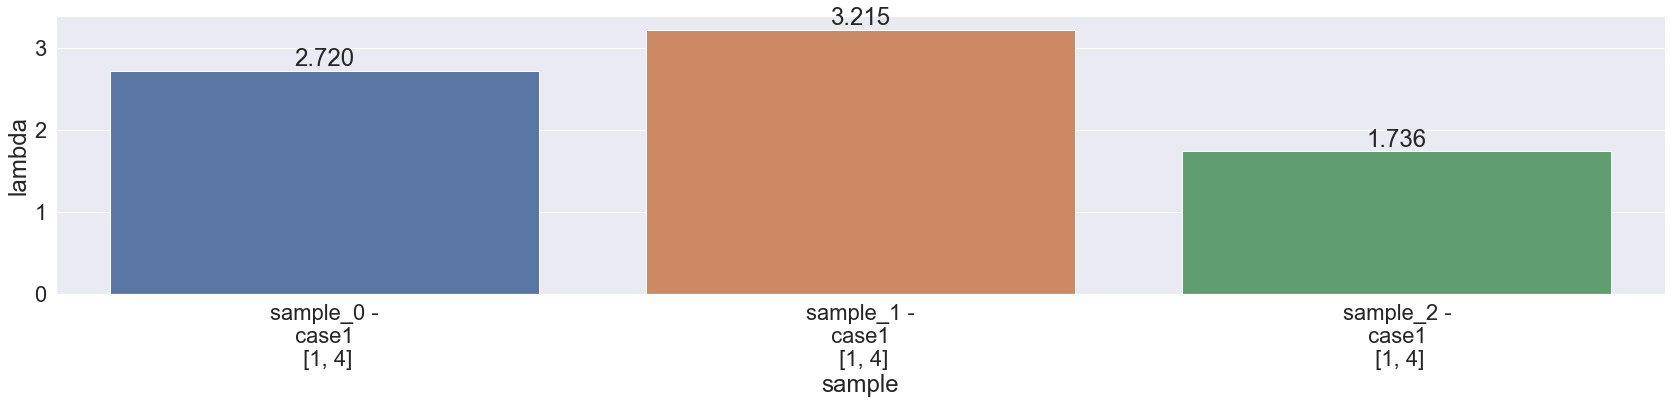

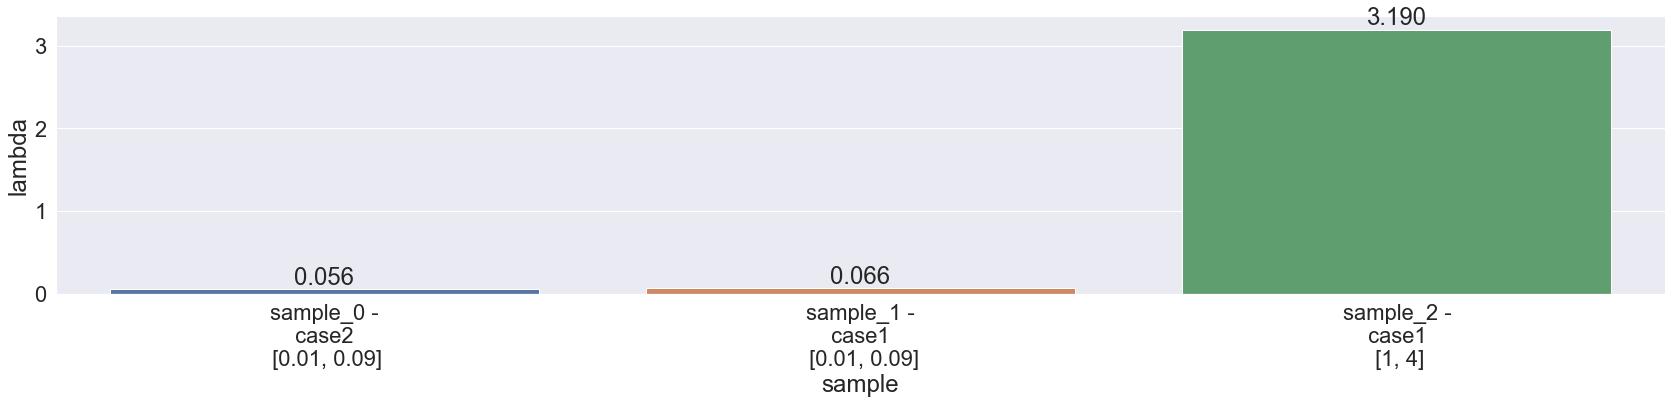

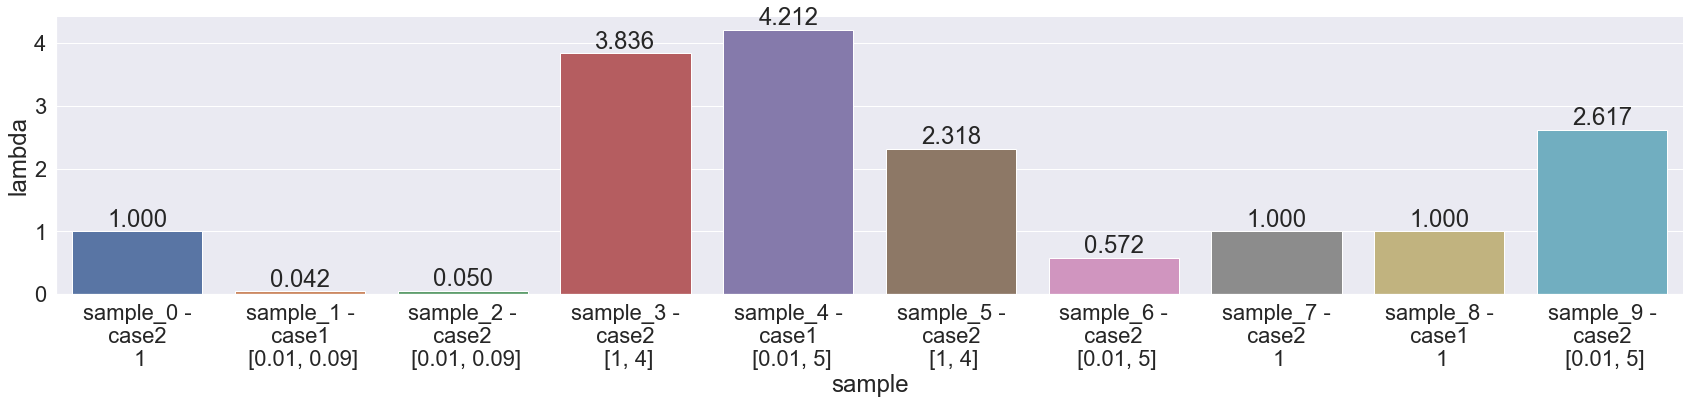

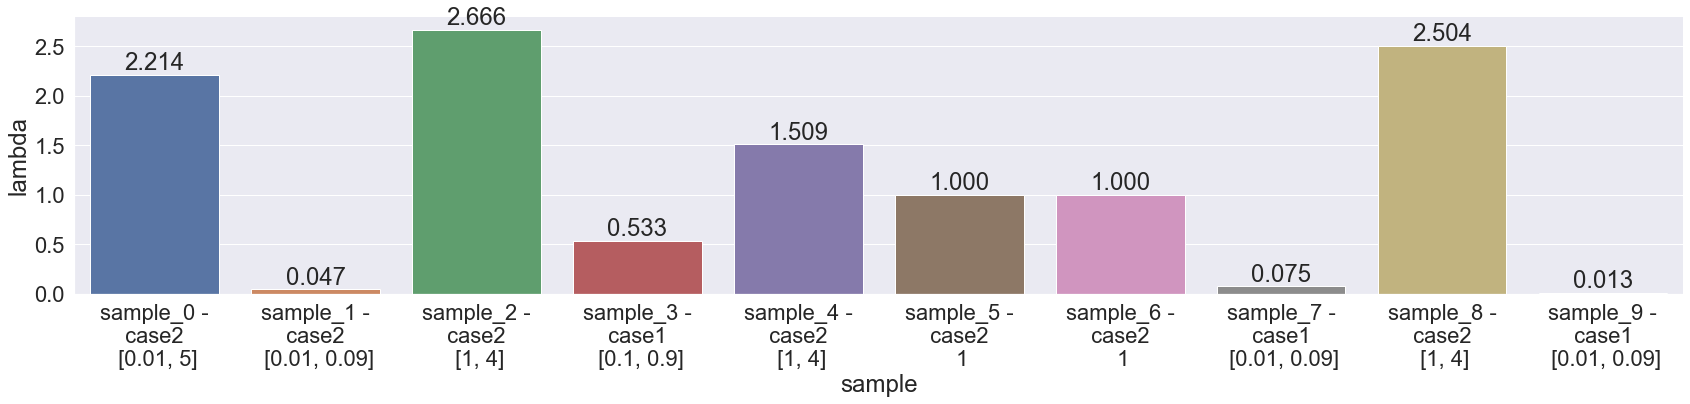

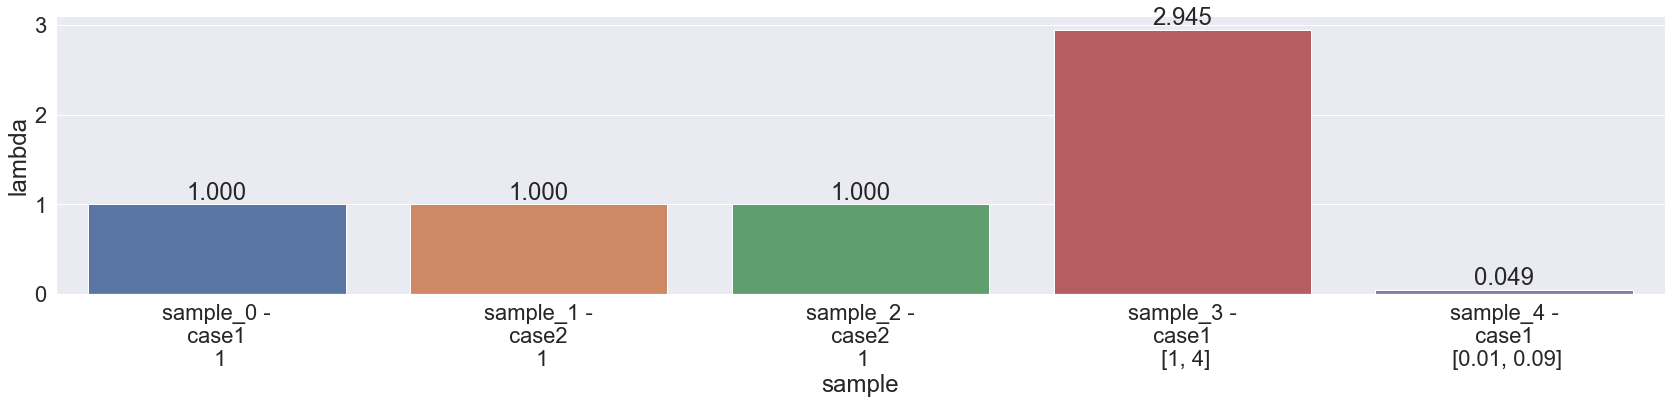

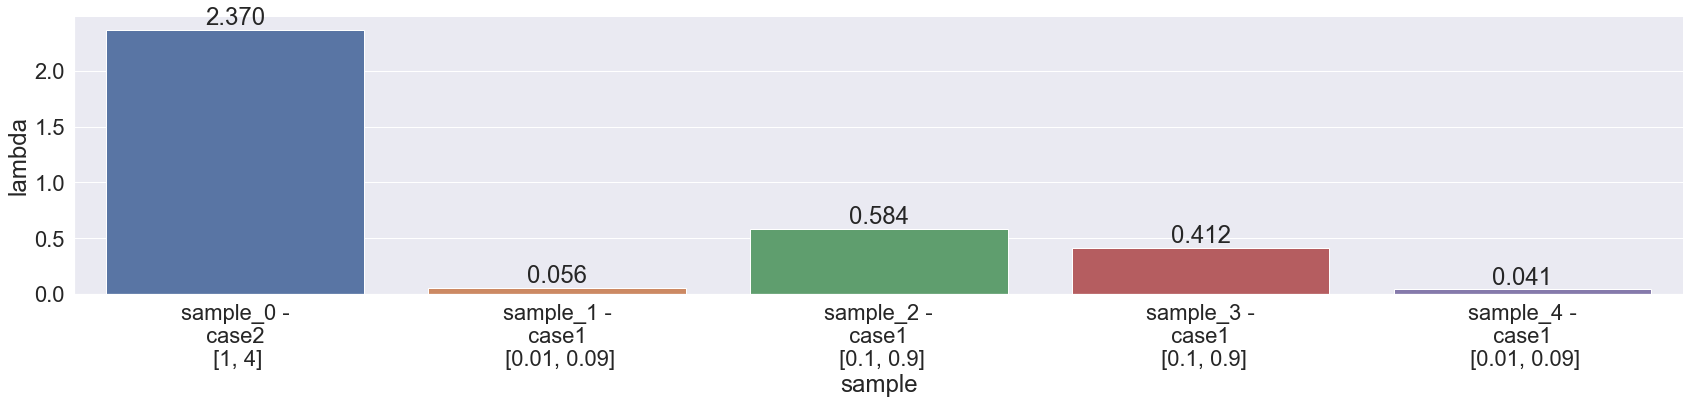

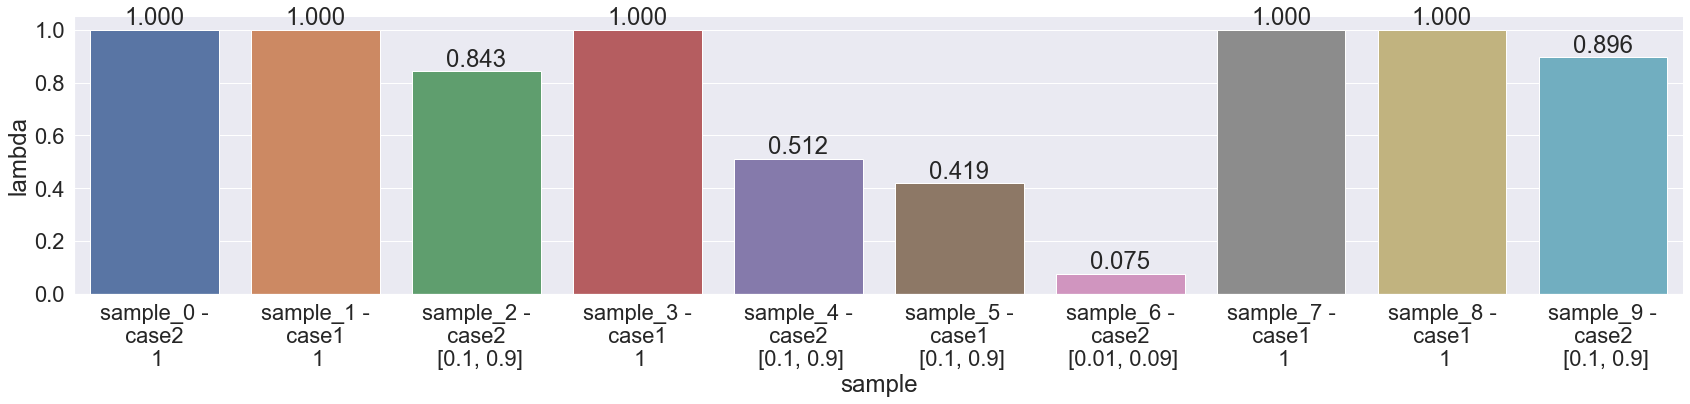

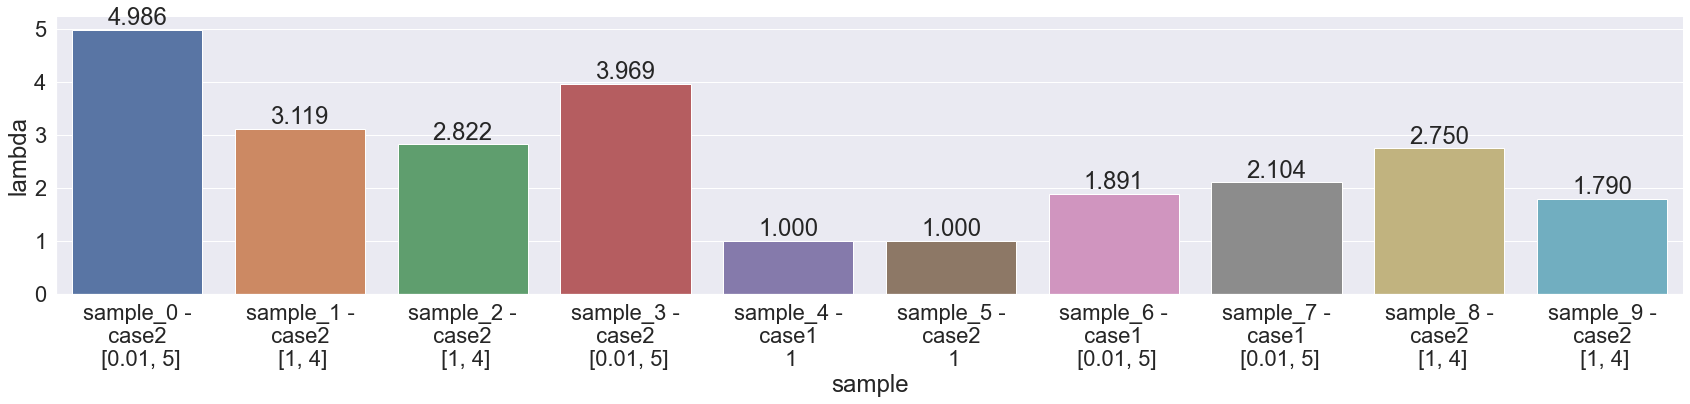

In [51]:
#read file per dataset
dataset = ['prison', 'tourism', 'labour', 'wikipedia']
models =['arima', 'ets']
levels = [LEVELS_prison, LEVELS_tourism, LEVELS_labour, LEVELS_wiki]
samples= [3, 10, 5, 10]

FC_ML = ['base', 'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']

for i in range(0, len(dataset)):
    data = dataset[i]
    sample_num = samples[i]
    level_num = levels[i]
    for model_name in models:
        print(data, level_num)
        draw_per_sample_lambda(data, model_name, level_num, sample_num)

### Overall best method lambda

In [40]:
def draw_lambda_plot(dataset, model, level, samples):
    lambda_sample = []
    best_ML_samples = get_results_across_samples(dataset, model, level, FC_ML, samples)
    best_ml = best_ML_samples['MSE'].loc['Overall',:].idxmax()
    ml_split = best_ml.split('_')

    for sample in range(0, samples):
        params = pd.read_csv(f'../results/expanding_window_results/best_params/{dataset}_{sample}_{model}_{best_ml}.csv', index_col=0)
        if ml_split[-1] == '1':
            lambda_val = 1.0
        else:
            lambda_val = float(params.transpose()['reconciliation_loss_lambda'].values[0])
        lambda_sample.append([f'sample_{sample} -\n {ml_split[0]} \n {ml_split[-1]}', lambda_val])

    plot_df = pd.DataFrame(lambda_sample, columns = ['sample', 'lambda'])
    sns.set(font_scale = 2)
    fig_bar = sns.catplot(x = 'sample', y = 'lambda', data = plot_df, height=6, aspect=4, kind='bar')

    # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = fig_bar.facet_axis(0, 0)

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.3f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    fig_bar.savefig(f'../results/expanding_window_results/figs/{dataset}_{model}.jpg')

prison ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
prison ['Australia', 'State', 'Gender', 'Legal', 'Indigenous']
tourism ['Australia', 'States', 'Regions']
tourism ['Australia', 'States', 'Regions']
labour ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
labour ['Total Employees', 'Main Occupation', 'Employment Status', 'Gender']
wikipedia ['Total', 'Language', 'Access', 'Agent', 'Article']
wikipedia ['Total', 'Language', 'Access', 'Agent', 'Article']


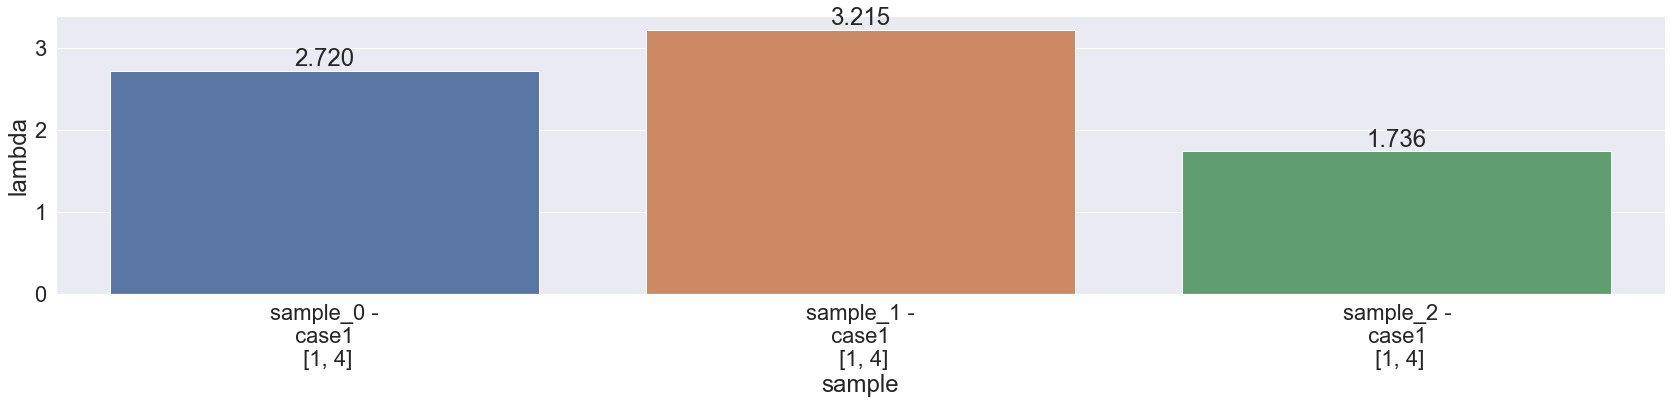

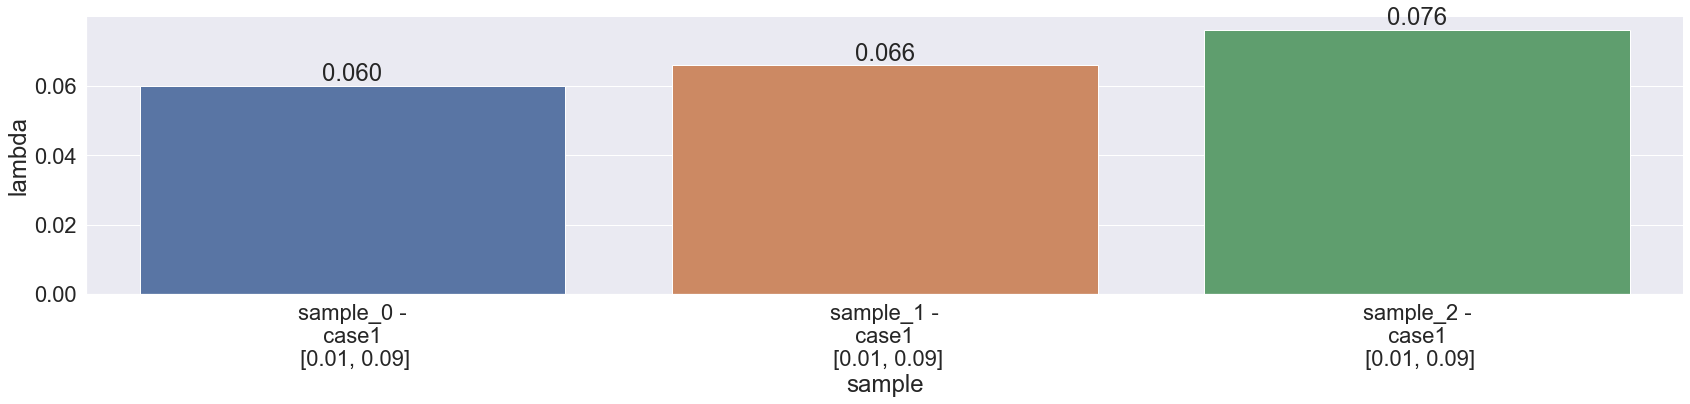

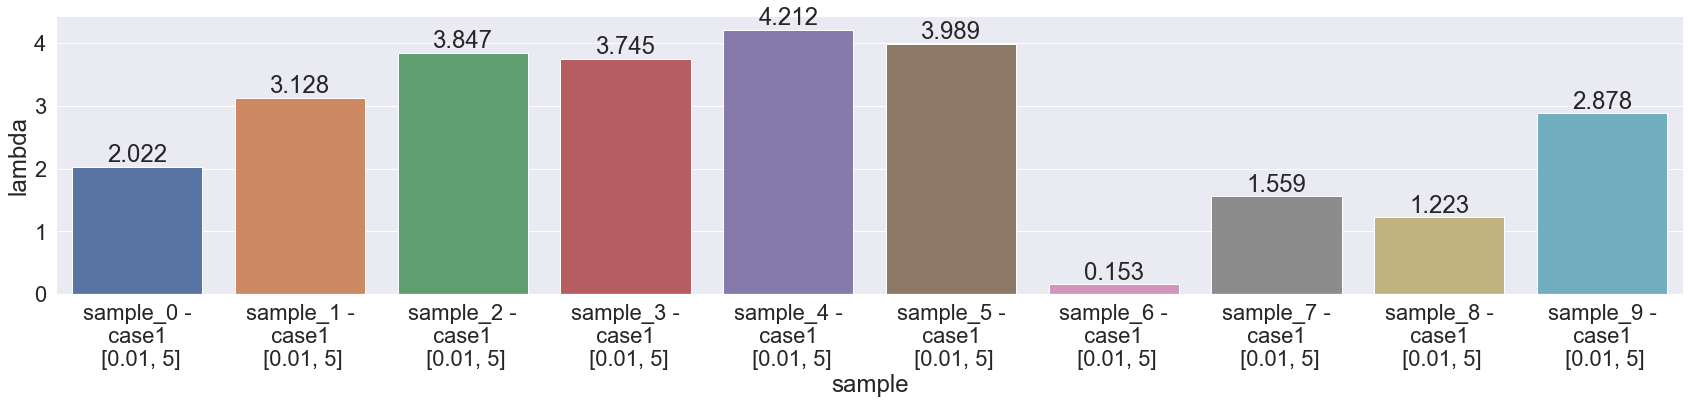

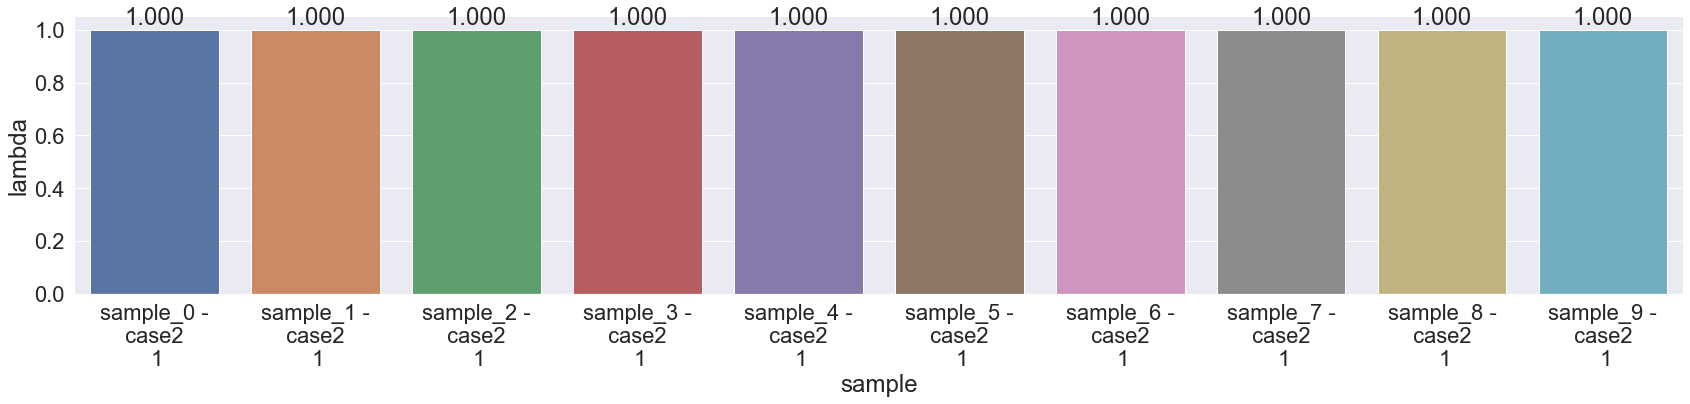

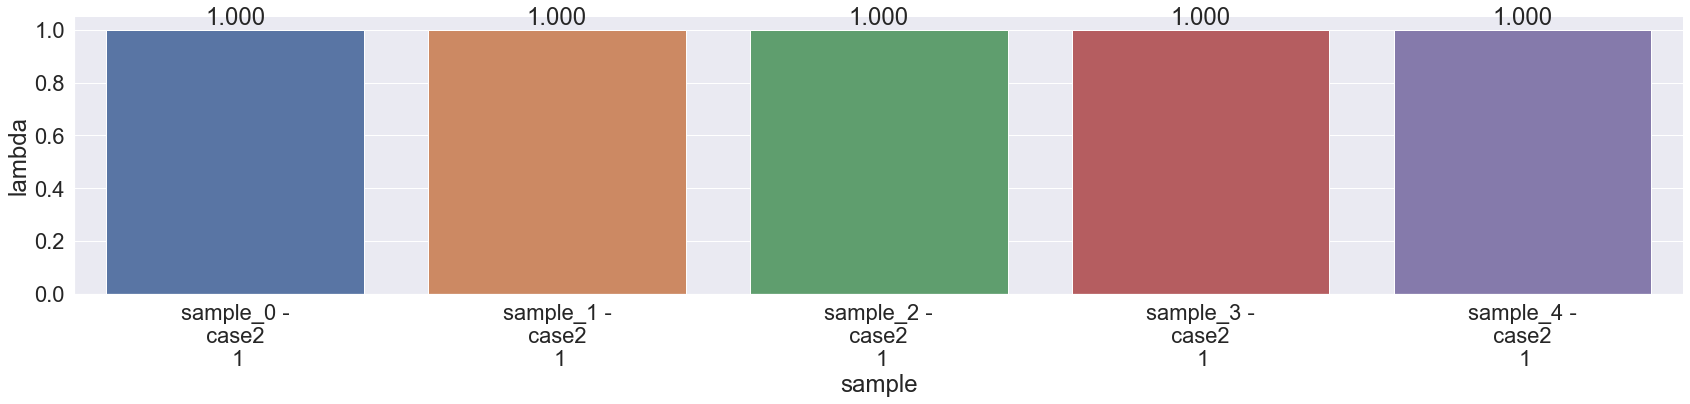

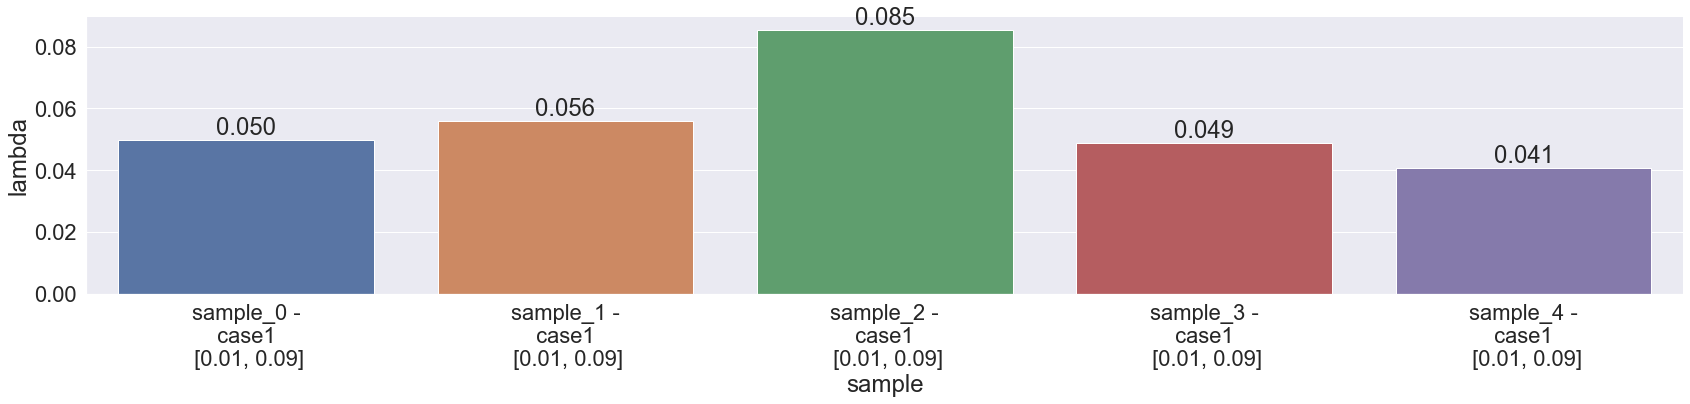

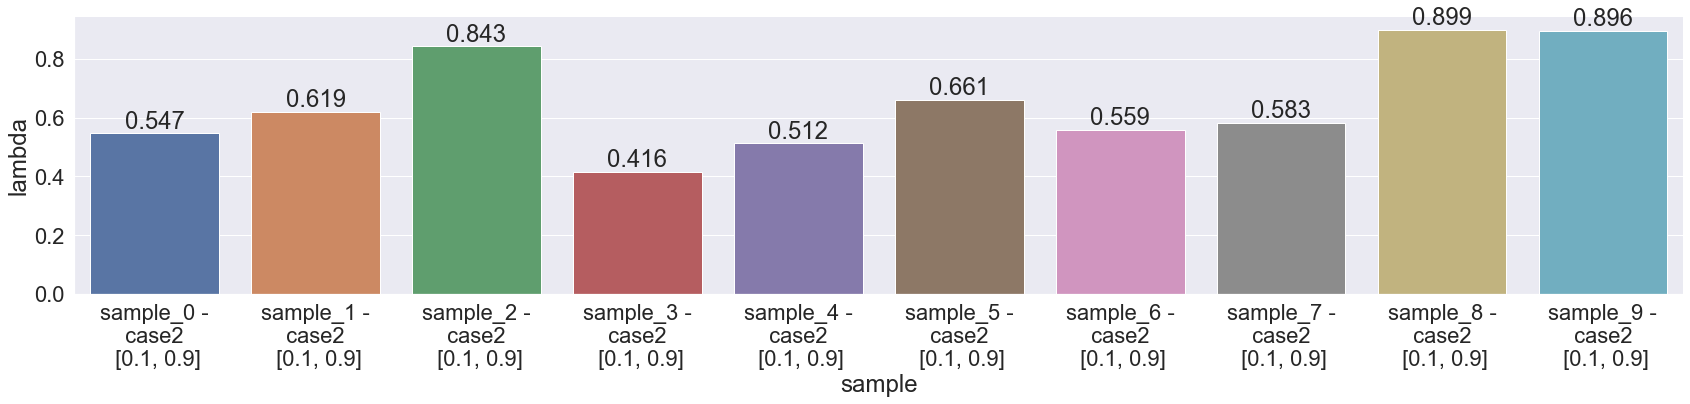

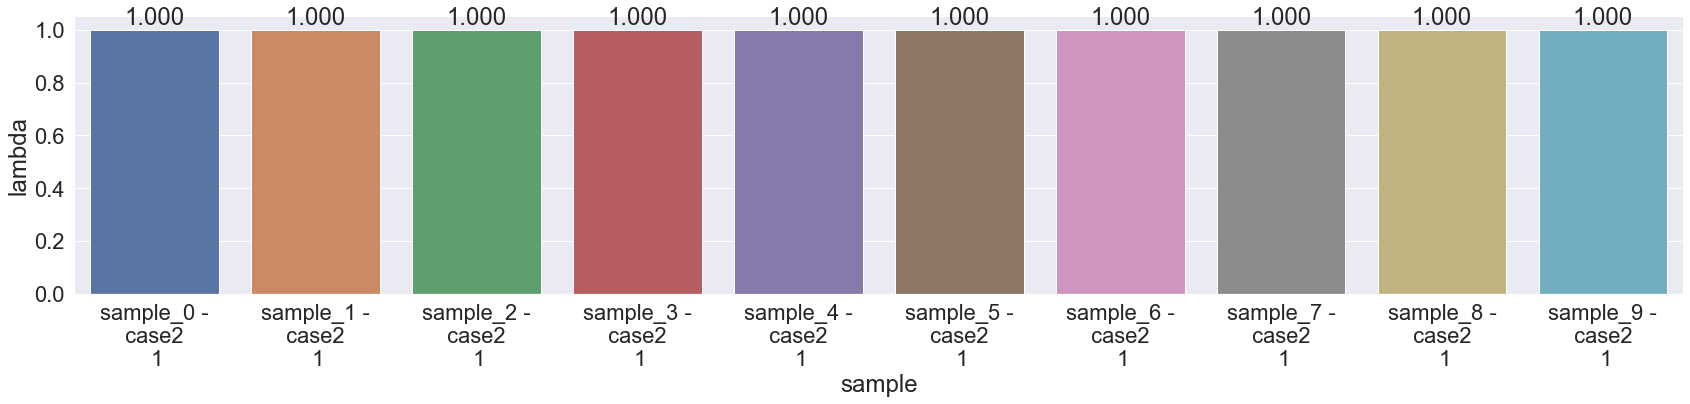

In [43]:
#read file per dataset
dataset = ['prison', 'tourism', 'labour', 'wikipedia']
models =['arima', 'ets']
levels = [LEVELS_prison, LEVELS_tourism, LEVELS_labour, LEVELS_wiki]
samples= [3, 10, 5, 10]

FC_ML = ['base', 'case1_lambda_1',
               'case1_lambda_[0.01, 0.09]',
               'case1_lambda_[0.1, 0.9]',
               'case1_lambda_[1, 4]',
               'case1_lambda_[0.01, 5]',
               'case2_lambda_1',
               'case2_lambda_[0.01, 0.09]',
               'case2_lambda_[0.1, 0.9]',
               'case2_lambda_[1, 4]',
               'case2_lambda_[0.01, 5]']

for i in range(0, len(dataset)):
    data = dataset[i]
    sample_num = samples[i]
    level_num = levels[i]
    for model_name in models:
        print(data, level_num)
        draw_lambda_plot(data, model_name, level_num, sample_num)